Beale synthetic function:

GP CBM versus STP nu = 3 CBM (winner)

https://www.sfu.ca/~ssurjano/beale.html

In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
### Inputs:

obj_func = 'Beale'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util_gp = 'CBMinimized'
util_stp = 'tCBMinimized'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [4]:
### Objective function:

if obj_func == 'Beale':
    
    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum 
    y_global_orig = y_lb * operator # targets global minimum
            
# Constraints:
    lb = -4.5 
    ub = +4.5

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}
    
# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return operator * (
                (1.500 - x1_training + x1_training * x2_training)**2 +
                (2.250 - x1_training + x1_training * x2_training**2)**2 +
                (2.625 - x1_training + x1_training * x2_training**3)**2 
                )
    

In [5]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [8]:
### Acquisition function - CBM:

class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-06, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'CBMinimized': self.CBMinimized,
            'tCBMinimized': self.tCBMinimized
        }

        self.f = mode_dict[mode]
   
    def CBMinimized(self, tau, mean, std):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
    
    def tCBMinimized(self, tau, mean, std, nu=df):
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (std + self.eps) * (gamma + np.sqrt(Beta_CBM))

    def eval(self, y_global_orig, mean, std):
    
        return self.f(y_global_orig, mean, std, **self.params)
        
    def t_eval(self, y_global_orig, mean, std, nu=df):
    
        return self.f(y_global_orig, mean, std, nu=df, **self.params)
    

In [9]:
n_start_AcqFunc = max_iter
inverse = -1


In [10]:
## GPGO_multi: 

n_start = n_start_AcqFunc

class GPGO_multi(GPGO):
  
    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        GP CBM: StdDev. y \t GP CBM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.eval(self.tau, new_mean, new_std)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.f_best = f_best
        self.f_best_min = f_best_min
        self.f_best_std = np.std(f_best)
        self.x_best = x_best
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_std)
        self.history.append(self.x_best_std)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        x_best_std = str(self.x_best_std)
        f_best_std = str(self.f_best_std)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            f_best_std = BOLD + OKGREEN + f_best_std + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_best_std, x_best_std))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [11]:
## GPGO_multi_STP: Student's-t

class GPGO_multi_STP(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t      STP CBM: StdDev. y \t STP CBM: StdDev. x '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        f = self.A.t_eval(self.tau, new_mean, new_std)

        return -f
   
    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        f_best_min = min(f_best)

        self.f_best = f_best
        self.f_best_min = f_best_min
        self.f_best_std = np.std(f_best)
        self.x_best = x_best
        self.x_best_std = np.std(x_best)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr        
        self.history.append(self.f_best_std)
        self.history.append(self.x_best_std)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, '', ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfunc = str(self.f_best_min)
        x_best_std = str(self.x_best_std)
        f_best_std = str(self.f_best_std)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            x_best_std = BOLD + OKGREEN + x_best_std + ENDC
            f_best_std = BOLD + OKGREEN + f_best_std + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_best_std, x_best_std))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [12]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_gp_1 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_1 = GPGO_multi(surrogate_gp_1, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP CBM: StdDev. y 	 GP CBM: StdDev. x 
init	 [-0.74680196  1.98292044]	 6.597029498756062	 6.597029498756062	    	    
init	 [-4.49897063 -1.77900685]	 1305.4710589552556	 6.597029498756062	    	    
init	 [-3.17919698 -3.66895265]	 28173.776013477825	 6.597029498756062	    	    
init	 [-2.8236581  -1.38995346]	 237.9931764117774	 6.597029498756062	    	    
init	 [-0.92909273  0.34935061]	 26.1790631757263	 6.597029498756062	    	    
1  	 [-2.52377989 -0.50196279]	 75.01150716354002	 6.597029498756062	 811.4061882927004	 3.7000994191897503
2  	 [4.5 4.5]	 174813.36328125	 6.597029498756062	 1.514501798463551e-05	 3.3647986815951225
3  	 [-2.50791183 -0.55066144]	 75.84110174541301	 6.597029498756062	 1458.029856321895	 3.7002686473900663
4  	 [ 4.5 -4.5]	 178131.83203125	 6.597029498756062	 1292.9700529169565	 3.904439616364808
5  	 [-4.5  4.5]	 169680.83203125	 6.597029498756062	 789.2896253340633	 3.174230199417310

In [13]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_gp_2 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_2 = GPGO_multi(surrogate_gp_2, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP CBM: StdDev. y 	 GP CBM: StdDev. x 
init	 [-0.57604588 -4.26666391]	 2377.8441741808733	 8.81624267140378	    	    
init	 [ 0.4469623  -0.58209847]	 8.81624267140378	 8.81624267140378	    	    
init	 [-0.71668978 -1.52698661]	 47.3742628518178	 8.81624267140378	    	    
init	 [-2.65816229  1.0734387 ]	 9.08861590265506	 8.81624267140378	    	    
init	 [-1.80310794 -2.09855452]	 510.2220943696988	 8.81624267140378	    	    
1  	 [ 0.24449295 -0.61206692]	 11.023806948178922	 8.81624267140378	 0.26317704485385146	 3.565658636058506
2  	 [4.5 4.5]	 174813.36328125	 8.81624267140378	 0.0009875965706728966	 3.1141910658330247
3  	 [ 4.5      -2.330512]	 4135.842673241978	 8.81624267140378	 0.34869377674199775	 3.9592091256105295
4  	 [-4.5  4.5]	 169680.83203125	 8.81624267140378	 0.42655573828049026	 3.561681114967922
5  	 [-1.99029262  0.75765935]	 27.58567606564185	 8.81624267140378	 59.92194018609159	 2.61235851808

In [14]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_gp_3 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_3 = GPGO_multi(surrogate_gp_3, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP CBM: StdDev. y 	 GP CBM: StdDev. x 
init	 [0.45718112 1.8733304 ]	 41.912714742005974	 41.912714742005974	    	    
init	 [-1.88185735  0.09744845]	 47.451188393399434	 41.912714742005974	    	    
init	 [3.53652259 3.5666378 ]	 27475.816689924115	 41.912714742005974	    	    
init	 [-3.36973221 -2.6348141 ]	 5079.048973002421	 41.912714742005974	    	    
init	 [-4.03679517 -0.53271141]	 138.4086524103332	 41.912714742005974	    	    
1	 [-4.5         1.09809207]	 4.234224860560838	 4.234224860560838	 1043.361652248326	 3.559301664426459
2  	 [ 4.5 -4.5]	 178131.83203125	 4.234224860560838	 34.12406965806612	 3.906137274738015
3  	 [-2.9878292  4.5      ]	 74238.41336800413	 4.234224860560838	 55.967721375040135	 3.581758867324991
4  	 [-4.5         0.64701487]	 68.1004981884198	 4.234224860560838	 55.92172147504901	 2.3067934878968748
5  	 [ 0.94975438 -1.21289628]	 7.63864321175239	 4.234224860560838	 999.8954266

In [15]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_gp_4 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_4 = GPGO_multi(surrogate_gp_4, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP CBM: StdDev. y 	 GP CBM: StdDev. x 
init	 [4.20326855 0.42509024]	 3.8409856613776237	 3.8409856613776237	    	    
init	 [4.25415924 1.93334394]	 1070.6518137934977	 3.8409856613776237	    	    
init	 [ 1.77955942 -2.55519454]	 1001.3529311398922	 3.8409856613776237	    	    
init	 [ 4.28647009 -4.4439277 ]	 150069.47442764963	 3.8409856613776237	    	    
init	 [-2.22315874 -0.58687621]	 67.08861688517413	 3.8409856613776237	    	    
1  	 [-4.5  4.5]	 169680.83203125	 3.8409856613776237	 0.00046124721284186216	 4.015189666116921
2  	 [ 4.10053968 -0.2832709 ]	 18.929355874208387	 3.8409856613776237	 1.3639501717617617	 2.932935726540584
3  	 [-4.5 -4.5]	 181853.61328125	 3.8409856613776237	 4.32695023701438	 3.15083119551702
4  	 [0.88261033 4.5       ]	 7143.198278267247	 3.8409856613776237	 6.096422345447001	 2.363979184027437
5  	 [0.31779763 0.44253226]	 11.178712612374834	 3.8409856613776237	 8.8119557105269

In [16]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_gp_5 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_5 = GPGO_multi(surrogate_gp_5, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP CBM: StdDev. y 	 GP CBM: StdDev. x 
init	 [-2.50206146  3.33659076]	 8263.905568073349	 0.311397019260738	    	    
init	 [-2.6395276   3.76749817]	 19560.15202528338	 0.311397019260738	    	    
init	 [-0.1042993   1.00569477]	 14.186578993925806	 0.311397019260738	    	    
init	 [2.39317071 0.16576189]	 0.311397019260738	 0.311397019260738	    	    
init	 [-1.82879549 -2.81050894]	 2208.9823086257425	 0.311397019260738	    	    
1  	 [ 4.5 -4.5]	 178131.83203125	 0.311397019260738	 0.11828564411320303	 3.9779769807767513
2  	 [4.5 4.5]	 174813.36328125	 0.311397019260738	 129.80830386963723	 3.260805709166712
3  	 [-4.5        -0.03093234]	 133.9616368591213	 0.311397019260738	 129.73417431611645	 3.579128043485336
4  	 [ 4.50000000e+00 -7.72555756e-04]	 17.59898401320571	 0.311397019260738	 129.66789814077313	 3.1684627191574943
5  	 [ 1.58639631 -1.20578363]	 15.85477565435088	 0.311397019260738	 108.7645575732

In [17]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_gp_6 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_6 = GPGO_multi(surrogate_gp_6, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP CBM: StdDev. y 	 GP CBM: StdDev. x 
init	 [ 3.53574136 -1.51218175]	 273.3122030790333	 10.038000709758428	    	    
init	 [ 2.89106211 -4.12473037]	 43803.250406689425	 10.038000709758428	    	    
init	 [-3.53108988  0.85546858]	 29.828433746298536	 10.038000709758428	    	    
init	 [ 0.26835626 -0.73073314]	 10.658925295067505	 10.038000709758428	    	    
init	 [-1.48132936  1.10267489]	 10.038000709758428	 10.038000709758428	    	    
1  	 [4.28897718 3.03217734]	 15404.22494396136	 10.038000709758428	 0.0009661754699496286	 3.665593427146986
2  	 [-4.5 -4.5]	 181853.61328125	 10.038000709758428	 443.41283613073745	 3.9467196184951856
3  	 [-4.5  4.5]	 169680.83203125	 10.038000709758428	 1059.5753090952708	 3.5109439551845285
4  	 [0.25898619 4.5       ]	 732.383187432724	 10.038000709758428	 1504.0013150974435	 2.8540627585066156
5  	 [-1.66601868 -0.91422642]	 59.31499843036169	 10.038000709758428	 1117.026

In [18]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_gp_7 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_7 = GPGO_multi(surrogate_gp_7, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP CBM: StdDev. y 	 GP CBM: StdDev. x 
init	 [-3.8132254   2.51926913]	 3321.1422834954587	 2.9676923934097053	    	    
init	 [-0.55431692  2.0111866 ]	 2.9676923934097053	 2.9676923934097053	    	    
init	 [4.30190561 0.34646283]	 6.32173172477085	 2.9676923934097053	    	    
init	 [ 0.01008417 -3.8515398 ]	 11.971894461559128	 2.9676923934097053	    	    
init	 [-2.08404918e+00 -1.05749257e-03]	 53.820317186435204	 2.9676923934097053	    	    
1  	 [0.37889366 2.10025002]	 49.35811724591768	 2.9676923934097053	 0.5416661290655084	 3.730407403318124
2  	 [-4.5 -4.5]	 181853.61328125	 2.9676923934097053	 40.1888943980222	 4.430790544292016
3  	 [ 4.5 -4.5]	 178131.83203125	 2.9676923934097053	 8.458740056307606	 3.2785720329487242
4  	 [4.5 4.5]	 174813.36328125	 2.9676923934097053	 5.857986483220558e-07	 2.8001491347125014
5	 [ 2.65201295e+00 -6.95755509e-04]	 1.4937316147194821	 1.4937316147194821	 65.289059161890

In [19]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_gp_8 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_8 = GPGO_multi(surrogate_gp_8, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP CBM: StdDev. y 	 GP CBM: StdDev. x 
init	 [3.36086463 4.21686597]	 66731.07602386779	 1.8693348557707412	    	    
init	 [3.32275086 0.27770122]	 1.8693348557707412	 1.8693348557707412	    	    
init	 [-2.40544505 -4.39741076]	 45883.361726150484	 1.8693348557707412	    	    
init	 [-0.62578064 -0.87883776]	 26.39306084619828	 1.8693348557707412	    	    
init	 [ 0.20407204 -0.19447384]	 11.649230998110728	 1.8693348557707412	    	    
1  	 [ 3.34144049 -0.43516188]	 12.054415443632589	 1.8693348557707412	 550.3264300810434	 3.4332738419222166
2  	 [-4.5  4.5]	 169680.83203125	 1.8693348557707412	 546.4526036376074	 4.02041627499318
3  	 [ 4.5 -4.5]	 178131.83203125	 1.8693348557707412	 3483.4177008781567	 3.7268354683618026
4	 [ 2.39289243 -0.17185461]	 1.7543334972318145	 1.7543334972318145	 3676.5558355065964	 2.6787972358267114
5  	 [ 2.50880105 -0.1599829 ]	 2.0376544511304107	 1.7543334972318145	 0.55085034081

In [20]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_gp_9 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_9 = GPGO_multi(surrogate_gp_9, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP CBM: StdDev. y 	 GP CBM: StdDev. x 
init	 [-4.40663262  0.01687133]	 127.7531900635415	 22.479204656276803	    	    
init	 [-0.03804036 -3.29553424]	 22.479204656276803	 22.479204656276803	    	    
init	 [-3.22100023 -2.53297192]	 3783.0538402600087	 22.479204656276803	    	    
init	 [-0.73342638 -2.26708948]	 157.51337782244087	 22.479204656276803	    	    
init	 [-3.74346314 -1.39051224]	 380.7730677650304	 22.479204656276803	    	    
1  	 [2.73365793 4.35023323]	 53339.37070055468	 22.479204656276803	 1.5508766402391425	 2.6618653022571013
2  	 [ 4.5 -4.5]	 178131.83203125	 22.479204656276803	 2.5409807549816996	 3.3904510257148646
3  	 [-4.5  4.5]	 169680.83203125	 22.479204656276803	 2.13513226321519	 2.88270244044907
4	 [4.5        0.17361523]	 12.82115719159232	 12.82115719159232	 2.829634108459824	 2.613472007882559
5	 [-0.82241217  1.56405692]	 2.288794395623513	 2.288794395623513	 2.499399985280117	 2.4

In [21]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_gp_10 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_10 = GPGO_multi(surrogate_gp_10, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP CBM: StdDev. y 	 GP CBM: StdDev. x 
init	 [ 2.44188579 -4.31323246]	 40500.708995062356	 15.229523981513257	    	    
init	 [1.20283411 2.23923494]	 281.8768699287936	 15.229523981513257	    	    
init	 [-0.01343689 -2.47683019]	 15.229523981513257	 15.229523981513257	    	    
init	 [-2.71743422  2.34477641]	 985.5637470908332	 15.229523981513257	    	    
init	 [-2.97800247 -3.70494167]	 26177.1461164703	 15.229523981513257	    	    
1  	 [4.5 4.5]	 174813.36328125	 15.229523981513257	 0.48330694058137863	 3.6323395825380174
2	 [-0.01600833 -1.48100764]	 14.59992763855108	 14.59992763855108	 206.53464021180812	 3.3279957214181812
3  	 [ 4.5        -0.27594801]	 25.50966936065976	 14.59992763855108	 321.3125837978013	 3.4847657243693027
4  	 [-4.5        -0.20920514]	 142.4802785596254	 14.59992763855108	 359.750988145583	 2.910293316838777
5  	 [-0.41197199  4.5       ]	 1222.7953735913866	 14.59992763855108	 510.

In [22]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_gp_11 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_11 = GPGO_multi(surrogate_gp_11, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP CBM: StdDev. y 	 GP CBM: StdDev. x 
init	 [-2.8775728  -4.32472283]	 59421.14819100274	 2.8907294990196846	    	    
init	 [-0.33103326  2.02440536]	 2.8907294990196846	 2.8907294990196846	    	    
init	 [-0.71816756 -0.13115612]	 25.271447350027046	 2.8907294990196846	    	    
init	 [-4.38497267 -0.11365553]	 133.2515796886641	 2.8907294990196846	    	    
init	 [3.97625987 3.1571558 ]	 16859.81677190551	 2.8907294990196846	    	    
1  	 [ 4.5 -4.5]	 178131.83203125	 2.8907294990196846	 1193.3241600066265	 4.137742651015459
2  	 [-4.5  4.5]	 169680.83203125	 2.8907294990196846	 310.6558903861798	 3.294672550078187
3  	 [ 1.48444217 -0.58493478]	 3.060307871299818	 2.8907294990196846	 649.071214802282	 1.7265798943276922
4  	 [ 1.48324703 -0.58513946]	 3.0624010805470183	 2.8907294990196846	 0.25729118453681243	 1.241400885470698
5  	 [-0.23466562  2.12661652]	 3.9160996815060454	 2.8907294990196846	 649.53685021

In [23]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_gp_12 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_12 = GPGO_multi(surrogate_gp_12, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP CBM: StdDev. y 	 GP CBM: StdDev. x 
init	 [-3.11253442  2.16044727]	 746.3412720881302	 48.45196617039589	    	    
init	 [-2.13016486  0.30365454]	 48.45196617039589	 48.45196617039589	    	    
init	 [-4.36882534  3.76872307]	 54651.235607336355	 48.45196617039589	    	    
init	 [ 3.60643369 -4.19920715]	 76007.68460600567	 48.45196617039589	    	    
init	 [ 4.11254403 -3.26511611]	 22941.17826205435	 48.45196617039589	    	    
1	 [-2.48337787  1.41316186]	 3.8857764788604188	 3.8857764788604188	 234.10419627389925	 3.526930385697131
2	 [-2.53263161  1.38547474]	 2.770087783099528	 2.770087783099528	 122.6625044393045	 3.6541410262481424
3  	 [-2.53492315  1.38769905]	 2.8823603142833387	 2.770087783099528	 59.83544135348934	 3.7201577779972035
4  	 [-2.53573224  1.38927566]	 2.9599630011564244	 2.770087783099528	 71.89703691075681	 2.303682917713415
5  	 [-2.53626746  1.39023986]	 3.00849784826935	 2.770087783

In [24]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_gp_13 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_13 = GPGO_multi(surrogate_gp_13, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP CBM: StdDev. y 	 GP CBM: StdDev. x 
init	 [ 2.4993217  -2.36212902]	 1312.0597023727128	 25.917758071459016	    	    
init	 [2.91850679 4.19174278]	 48757.43948599124	 25.917758071459016	    	    
init	 [ 4.25341003 -0.41895677]	 25.917758071459016	 25.917758071459016	    	    
init	 [0.98138216 2.47973863]	 337.8750512678324	 25.917758071459016	    	    
init	 [1.2745201  1.99816407]	 177.1374160884886	 25.917758071459016	    	    
1	 [0.68616841 0.87186966]	 12.072275435399341	 12.072275435399341	 1.0263256512970984	 2.913665552724107
2  	 [-4.5 -4.5]	 181853.61328125	 12.072275435399341	 1.7570549183716677	 3.1144054698355084
3  	 [-4.5  4.5]	 169680.83203125	 12.072275435399341	 1.2219893962178527	 3.3585071935747965
4  	 [-2.31138284 -0.01986263]	 60.044658919948034	 12.072275435399341	 1.3867282223740347	 3.608235517347266
5  	 [-0.80203185 -2.08636311]	 130.71944601328	 12.072275435399341	 999.4149479863994	 

In [25]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_gp_14 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_14 = GPGO_multi(surrogate_gp_14, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP CBM: StdDev. y 	 GP CBM: StdDev. x 
init	 [0.12549009 2.45848547]	 30.19066754742359	 11.367015527968295	    	    
init	 [ 3.33384917 -4.42757746]	 88548.3950659154	 11.367015527968295	    	    
init	 [-1.71237667  4.11843365]	 13933.414320383567	 11.367015527968295	    	    
init	 [ 0.11805041 -1.63544018]	 11.367015527968295	 11.367015527968295	    	    
init	 [ 0.35279944 -2.50870552]	 27.90050047415725	 11.367015527968295	    	    
1  	 [0.9462644  1.71864453]	 63.57352915255465	 11.367015527968295	 2.4637350919322962	 3.44612991760742
2  	 [-4.5 -4.5]	 181853.61328125	 11.367015527968295	 0.8873138349791636	 3.659347114926162
3  	 [4.5 4.5]	 174813.36328125	 11.367015527968295	 0.9625303863192358	 3.6012285610321757
4  	 [-4.5         0.43899209]	 96.28965204105123	 11.367015527968295	 1.9580221921683196	 3.553588132805522
5  	 [ 4.5        -0.08563764]	 19.902036804751372	 11.367015527968295	 1.859954205485789

In [26]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_gp_15 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_15 = GPGO_multi(surrogate_gp_15, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP CBM: StdDev. y 	 GP CBM: StdDev. x 
init	 [ 3.13935928 -2.88993668]	 6575.875821208801	 47.082686538130915	    	    
init	 [-4.01073107 -1.24615399]	 317.710908287677	 47.082686538130915	    	    
init	 [-2.02139164  0.27000202]	 47.082686538130915	 47.082686538130915	    	    
init	 [-1.74672976 -1.75973077]	 234.8792968363759	 47.082686538130915	    	    
init	 [-3.49432851 -2.25090888]	 2421.671033348018	 47.082686538130915	    	    
1  	 [-4.5         0.13268602]	 124.3066440459835	 47.082686538130915	 18.881934055266306	 3.7866427255222788
2  	 [4.5 4.5]	 174813.36328125	 47.082686538130915	 12.786417568624712	 3.4381323524528478
3  	 [-3.10802295  4.48335821]	 78619.74513995284	 47.082686538130915	 12.630448936170826	 3.533227286224921
4	 [1.39472311 1.04208166]	 15.933911132157405	 15.933911132157405	 20.698163649845235	 2.771280180606871
5  	 [-0.29638448 -4.5       ]	 917.5075992832882	 15.933911132157405	 

In [27]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_gp_16 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_16 = GPGO_multi(surrogate_gp_16, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP CBM: StdDev. y 	 GP CBM: StdDev. x 
init	 [-2.49038029  0.20847007]	 59.442894178636664	 59.442894178636664	    	    
init	 [ 0.45631311 -4.08958245]	 932.9374489641153	 59.442894178636664	    	    
init	 [-1.25344048 -2.49227152]	 594.9494957841517	 59.442894178636664	    	    
init	 [ 1.69853546 -3.02641717]	 2418.389440420566	 59.442894178636664	    	    
init	 [-3.8670762   3.96909774]	 58473.38862292419	 59.442894178636664	    	    
1  	 [4.5 4.5]	 174813.36328125	 59.442894178636664	 3.3569104242924075	 4.043036281142192
2  	 [-4.5 -4.5]	 181853.61328125	 59.442894178636664	 3.3987619842691457	 3.6453921213360863
3	 [0.53451697 1.22562465]	 18.42172517800162	 18.42172517800162	 55.79251883643334	 3.0657699588565253
4  	 [ 4.5        -0.44434265]	 32.00109970259423	 18.42172517800162	 4.093544445363932	 2.9087373361286453
5	 [1.93677184 0.55107092]	 2.2349010940340954	 2.2349010940340954	 2.76654048810057	 2.57

In [28]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_gp_17 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_17 = GPGO_multi(surrogate_gp_17, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP CBM: StdDev. y 	 GP CBM: StdDev. x 
init	 [-1.84801498  0.2752808 ]	 43.39160388622011	 6.891623366037299	    	    
init	 [-2.77631292 -3.88889678]	 30048.58268621874	 6.891623366037299	    	    
init	 [2.58286914 1.4070017 ]	 81.72560623465196	 6.891623366037299	    	    
init	 [1.23768806 0.68042604]	 6.891623366037299	 6.891623366037299	    	    
init	 [-4.14843375 -1.27967756]	 359.4343933746243	 6.891623366037299	    	    
1  	 [ 4.5 -4.5]	 178131.83203125	 6.891623366037299	 0.021900145229469755	 4.217849576860105
2  	 [-4.5  4.5]	 169680.83203125	 6.891623366037299	 0.9636412414476763	 3.5362495606908224
3  	 [4.5 4.5]	 174813.36328125	 6.891623366037299	 1.2707665096503853	 2.2360848083964027
4	 [2.42744102 0.42261095]	 0.22026610941444486	 0.22026610941444486	 847.355004595906	 2.0026096765470216
5  	 [2.33370459 0.49285553]	 0.6592844643058426	 0.22026610941444486	 846.5030713841785	 1.9408455581406645
6  

In [29]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_gp_18 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_18 = GPGO_multi(surrogate_gp_18, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP CBM: StdDev. y 	 GP CBM: StdDev. x 
init	 [1.35336818 0.04908036]	 2.472652645883837	 2.472652645883837	    	    
init	 [ 3.40741324 -2.86343797]	 7379.017314590048	 2.472652645883837	    	    
init	 [3.17009762 2.25122657]	 1528.3101419799655	 2.472652645883837	    	    
init	 [1.49491501 4.39105903]	 17224.913295283764	 2.472652645883837	    	    
init	 [-2.1872842  -4.24524667]	 31030.348242396165	 2.472652645883837	    	    
1  	 [ 0.35252655 -0.06916659]	 10.031745982746964	 2.472652645883837	 224.8325316980192	 3.669852925695727
2  	 [-4.5         2.12030663]	 1473.7753289010866	 2.472652645883837	 320.1488631256826	 3.7089784115630713
3  	 [-1.15387497  0.45527669]	 28.01483629516642	 2.472652645883837	 238.58451123424882	 3.432254748760261
4  	 [ 0.69648412 -0.10223175]	 6.688667526059637	 2.472652645883837	 326.1520988264494	 3.5769397248338666
5  	 [ 0.69950075 -0.09689444]	 6.666434295533444	 2.4726526458

In [30]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_gp_19 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_19 = GPGO_multi(surrogate_gp_19, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP CBM: StdDev. y 	 GP CBM: StdDev. x 
init	 [-3.62219758  2.35124745]	 1879.409018573639	 63.544086067314716	    	    
init	 [-2.27755824 -3.25681481]	 7496.243410303341	 63.544086067314716	    	    
init	 [-1.51698093 -3.75300391]	 7497.407542620609	 63.544086067314716	    	    
init	 [1.54779373 2.75934418]	 1302.4341957421634	 63.544086067314716	    	    
init	 [4.34467723 1.22094661]	 63.544086067314716	 63.544086067314716	    	    
1  	 [ 4.5 -4.5]	 178131.83203125	 63.544086067314716	 35.061624977791396	 4.292726406376255
2  	 [4.5 4.5]	 174813.36328125	 63.544086067314716	 59.30739430542092	 3.9095970657346917
3	 [4.32863904 0.4532675 ]	 3.856872797379538	 3.856872797379538	 111.86790297588523	 3.733442763145577
4	 [4.327595   0.48570429]	 3.0993558032584048	 3.0993558032584048	 45.78683350585398	 3.09396145528921
5	 [4.32778103 0.49746441]	 2.837942833879913	 2.837942833879913	 71.96867467262982	 3.38198889877

In [31]:
### Bayesian optimisation runs (x20): 'GP' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_gp_20 = GaussianProcess(cov_func, optimize=hyperOpt)

gp_20 = GPGO_multi(surrogate_gp_20, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
gp_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP CBM: StdDev. y 	 GP CBM: StdDev. x 
init	 [0.79317721 3.57942355]	 1607.3829986954497	 30.55204392634667	    	    
init	 [3.52377657 2.8425373 ]	 7209.150060592592	 30.55204392634667	    	    
init	 [-4.17699373  1.72581824]	 253.68900136908488	 30.55204392634667	    	    
init	 [-1.09187152  0.16659851]	 30.55204392634667	 30.55204392634667	    	    
init	 [ 1.42156319 -2.75534804]	 963.9362838324588	 30.55204392634667	    	    
1  	 [-4.5 -4.5]	 181853.61328125	 30.55204392634667	 3.72837038079099	 3.827436636525326
2  	 [ 4.5 -4.5]	 178131.83203125	 30.55204392634667	 200.71507920384244	 3.4983174068742184
3  	 [-4.5  4.5]	 169680.83203125	 30.55204392634667	 198.13593697931086	 3.4618504329532866
4	 [-4.08134064  0.88543396]	 28.67979686155381	 28.67979686155381	 105.58556209567539	 3.1634044868041884
5	 [-3.65675533  0.95619784]	 18.842718482407328	 18.842718482407328	 80.32128901873045	 2.6340132875683704
6  	

In [32]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_stp_1 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_1 = GPGO_multi_STP(surrogate_stp_1, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	      STP CBM: StdDev. y 	 STP CBM: StdDev. x 
init	 [-0.74680196  1.98292044]	 6.597029498756062	 6.597029498756062	    	    
init	 [-4.49897063 -1.77900685]	 1305.4710589552556	 6.597029498756062	    	    
init	 [-3.17919698 -3.66895265]	 28173.776013477825	 6.597029498756062	    	    
init	 [-2.8236581  -1.38995346]	 237.9931764117774	 6.597029498756062	    	    
init	 [-0.92909273  0.34935061]	 26.1790631757263	 6.597029498756062	    	    
1  	 [-3.53293661  0.81150384]	 34.869905958738116	 6.597029498756062	 949.6048987971036	 3.727657165724301
2  	 [ 4.5        -4.29367656]	 135233.99872656938	 6.597029498756062	 121.5855416371894	 3.371835493952734
3  	 [4.5 4.5]	 174813.36328125	 6.597029498756062	 1975.1023574973863	 4.034818334462952
4  	 [-4.5  4.5]	 169680.83203125	 6.597029498756062	 2492.411892411503	 3.363438178613054
5	 [2.36692073 0.05978621]	 0.6048517475487423	 0.6048517475487423	 2527.106028579377	 2.510317

In [33]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_stp_2 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_2 = GPGO_multi_STP(surrogate_stp_2, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	      STP CBM: StdDev. y 	 STP CBM: StdDev. x 
init	 [-0.57604588 -4.26666391]	 2377.8441741808733	 8.81624267140378	    	    
init	 [ 0.4469623  -0.58209847]	 8.81624267140378	 8.81624267140378	    	    
init	 [-0.71668978 -1.52698661]	 47.3742628518178	 8.81624267140378	    	    
init	 [-2.65816229  1.0734387 ]	 9.08861590265506	 8.81624267140378	    	    
init	 [-1.80310794 -2.09855452]	 510.2220943696988	 8.81624267140378	    	    
1  	 [4.5 4.5]	 174813.36328125	 8.81624267140378	 0.2623699139042837	 3.970946443807406
2  	 [ 4.5        -2.33644298]	 4193.598448632004	 8.81624267140378	 0.32006975071134036	 4.111343426791512
3  	 [-4.5  4.5]	 169680.83203125	 8.81624267140378	 65.78663252574854	 3.9276514937752993
4  	 [-4.5 -4.5]	 181853.61328125	 8.81624267140378	 118.41866152525515	 3.0482547750022766
5  	 [0.07449882 2.78542402]	 27.558220094133276	 8.81624267140378	 1325.545738403127	 2.689718964238412
6	 [2.99976298 

In [34]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_stp_3 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_3 = GPGO_multi_STP(surrogate_stp_3, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	      STP CBM: StdDev. y 	 STP CBM: StdDev. x 
init	 [0.45718112 1.8733304 ]	 41.912714742005974	 41.912714742005974	    	    
init	 [-1.88185735  0.09744845]	 47.451188393399434	 41.912714742005974	    	    
init	 [3.53652259 3.5666378 ]	 27475.816689924115	 41.912714742005974	    	    
init	 [-3.36973221 -2.6348141 ]	 5079.048973002421	 41.912714742005974	    	    
init	 [-4.03679517 -0.53271141]	 138.4086524103332	 41.912714742005974	    	    
1  	 [ 2.52283288 -1.74272821]	 259.55509339560894	 41.912714742005974	 39.99486888179021	 3.0421467798942663
2  	 [-4.5         2.44842854]	 3906.4866767218664	 41.912714742005974	 75.26672725561029	 4.146078276504296
3  	 [ 4.5 -4.5]	 178131.83203125	 41.912714742005974	 110.27166419184839	 3.776214655332703
4  	 [-1.17481522  4.5       ]	 11083.203632399458	 41.912714742005974	 2856.0517706827677	 3.3283222689022582
5  	 [-0.15376504 -4.5       ]	 287.9308186825642	 41.912714742005

In [35]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_stp_4 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_4 = GPGO_multi_STP(surrogate_stp_4, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	      STP CBM: StdDev. y 	 STP CBM: StdDev. x 
init	 [4.20326855 0.42509024]	 3.8409856613776237	 3.8409856613776237	    	    
init	 [4.25415924 1.93334394]	 1070.6518137934977	 3.8409856613776237	    	    
init	 [ 1.77955942 -2.55519454]	 1001.3529311398922	 3.8409856613776237	    	    
init	 [ 4.28647009 -4.4439277 ]	 150069.47442764963	 3.8409856613776237	    	    
init	 [-2.22315874 -0.58687621]	 67.08861688517413	 3.8409856613776237	    	    
1  	 [-4.5  4.5]	 169680.83203125	 3.8409856613776237	 12.188005800439216	 4.0807397041430535
2  	 [-4.5 -4.5]	 181853.61328125	 3.8409856613776237	 75.48628268715662	 3.1129641065273415
3  	 [0.88997841 4.37964623]	 6212.227499146847	 3.8409856613776237	 7986.398932358383	 2.9296134076077003
4  	 [0.77930271 0.53221484]	 8.00428225408437	 3.8409856613776237	 17720.448368785725	 2.9203466103204208
5  	 [-0.2459832 -4.5      ]	 653.7072045995599	 3.8409856613776237	 3759.788640481146	

In [36]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_stp_5 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_5 = GPGO_multi_STP(surrogate_stp_5, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	      STP CBM: StdDev. y 	 STP CBM: StdDev. x 
init	 [-2.50206146  3.33659076]	 8263.905568073349	 0.311397019260738	    	    
init	 [-2.6395276   3.76749817]	 19560.15202528338	 0.311397019260738	    	    
init	 [-0.1042993   1.00569477]	 14.186578993925806	 0.311397019260738	    	    
init	 [2.39317071 0.16576189]	 0.311397019260738	 0.311397019260738	    	    
init	 [-1.82879549 -2.81050894]	 2208.9823086257425	 0.311397019260738	    	    
1  	 [ 4.5 -4.5]	 178131.83203125	 0.311397019260738	 3.0182245789748388	 4.193672320042902
2  	 [4.5 4.5]	 174813.36328125	 0.311397019260738	 612.8940800597559	 3.7817351914308266
3  	 [-4.5 -4.5]	 181853.61328125	 0.311397019260738	 676.3701821983667	 3.814435870314916
4  	 [-4.5         0.16586694]	 121.98020769770423	 0.311397019260738	 733.2510271775058	 3.317183524862745
5  	 [ 0.95813986 -2.19001132]	 107.59317174630142	 0.311397019260738	 460.37754676759425	 2.729896252084734
6  

In [37]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_stp_6 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_6 = GPGO_multi_STP(surrogate_stp_6, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	      STP CBM: StdDev. y 	 STP CBM: StdDev. x 
init	 [ 3.53574136 -1.51218175]	 273.3122030790333	 10.038000709758428	    	    
init	 [ 2.89106211 -4.12473037]	 43803.250406689425	 10.038000709758428	    	    
init	 [-3.53108988  0.85546858]	 29.828433746298536	 10.038000709758428	    	    
init	 [ 0.26835626 -0.73073314]	 10.658925295067505	 10.038000709758428	    	    
init	 [-1.48132936  1.10267489]	 10.038000709758428	 10.038000709758428	    	    
1  	 [4.25528696 1.11328007]	 32.59986923309303	 10.038000709758428	 0.5792388486032374	 4.046556604721538
2  	 [-4.5 -4.5]	 181853.61328125	 10.038000709758428	 0.03557266025074017	 4.297778865064684
3  	 [1.19497955 4.5       ]	 12841.083052024373	 10.038000709758428	 1899.1170389274637	 3.5525594209977065
4  	 [-4.5  4.5]	 169680.83203125	 10.038000709758428	 1371.8435649630055	 4.1204676763763874
5  	 [4.5 4.5]	 174813.36328125	 10.038000709758428	 1936.690112205727	 3.145398

In [38]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_stp_7 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_7 = GPGO_multi_STP(surrogate_stp_7, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	      STP CBM: StdDev. y 	 STP CBM: StdDev. x 
init	 [-3.8132254   2.51926913]	 3321.1422834954587	 2.9676923934097053	    	    
init	 [-0.55431692  2.0111866 ]	 2.9676923934097053	 2.9676923934097053	    	    
init	 [4.30190561 0.34646283]	 6.32173172477085	 2.9676923934097053	    	    
init	 [ 0.01008417 -3.8515398 ]	 11.971894461559128	 2.9676923934097053	    	    
init	 [-2.08404918e+00 -1.05749257e-03]	 53.820317186435204	 2.9676923934097053	    	    
1  	 [1.84967754 4.18905978]	 19833.952753238307	 2.9676923934097053	 0.03678993105202467	 3.870542604043733
2  	 [ 4.5 -4.5]	 178131.83203125	 2.9676923934097053	 80.41762043689432	 4.011317624395505
3  	 [-4.5 -4.5]	 181853.61328125	 2.9676923934097053	 422.7578484483117	 4.00626492014274
4  	 [-3.5381093  -1.17462676]	 226.89781537510947	 2.9676923934097053	 1.4551915228366852e-11	 2.677604799365907
5  	 [ 1.1935121  -0.74132089]	 4.160201921693568	 2.9676923934097053	 42

In [39]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_stp_8 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_8 = GPGO_multi_STP(surrogate_stp_8, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	      STP CBM: StdDev. y 	 STP CBM: StdDev. x 
init	 [3.36086463 4.21686597]	 66731.07602386779	 1.8693348557707412	    	    
init	 [3.32275086 0.27770122]	 1.8693348557707412	 1.8693348557707412	    	    
init	 [-2.40544505 -4.39741076]	 45883.361726150484	 1.8693348557707412	    	    
init	 [-0.62578064 -0.87883776]	 26.39306084619828	 1.8693348557707412	    	    
init	 [ 0.20407204 -0.19447384]	 11.649230998110728	 1.8693348557707412	    	    
1  	 [ 3.81659363 -3.60434002]	 34929.0787604046	 1.8693348557707412	 785.0793412565566	 4.179727017087571
2  	 [-4.5  4.5]	 169680.83203125	 1.8693348557707412	 2423.8697943220673	 3.99578205876361
3  	 [-4.5        -0.36304781]	 150.06125945482415	 1.8693348557707412	 4310.314437184996	 2.966484448475207
4  	 [-0.5461566   2.57308492]	 38.697144796753825	 1.8693348557707412	 4820.028502218959	 3.0591179464502423
5  	 [-2.4100002   0.92926494]	 19.057896433277797	 1.8693348557707412	

In [40]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_stp_9 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_9 = GPGO_multi_STP(surrogate_stp_9, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	      STP CBM: StdDev. y 	 STP CBM: StdDev. x 
init	 [-4.40663262  0.01687133]	 127.7531900635415	 22.479204656276803	    	    
init	 [-0.03804036 -3.29553424]	 22.479204656276803	 22.479204656276803	    	    
init	 [-3.22100023 -2.53297192]	 3783.0538402600087	 22.479204656276803	    	    
init	 [-0.73342638 -2.26708948]	 157.51337782244087	 22.479204656276803	    	    
init	 [-3.74346314 -1.39051224]	 380.7730677650304	 22.479204656276803	    	    
1  	 [2.73365793 4.35023323]	 53339.37070055468	 22.479204656276803	 5.742317271106132	 2.694547463462519
2  	 [ 4.49443445 -3.63069242]	 50698.449666897395	 22.479204656276803	 59.55280224816723	 3.925435686949444
3  	 [-3.24764682  4.5       ]	 87869.61201357104	 22.479204656276803	 4261.5650356896385	 3.1247160914866554
4	 [ 1.45819671 -0.02499372]	 1.9898012872111077	 1.9898012872111077	 76.75808932342099	 2.5673744604253104
5	 [4.5        0.56578974]	 1.9848269795455777	 1.98

In [41]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_stp_10 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_10 = GPGO_multi_STP(surrogate_stp_10, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	      STP CBM: StdDev. y 	 STP CBM: StdDev. x 
init	 [ 2.44188579 -4.31323246]	 40500.708995062356	 15.229523981513257	    	    
init	 [1.20283411 2.23923494]	 281.8768699287936	 15.229523981513257	    	    
init	 [-0.01343689 -2.47683019]	 15.229523981513257	 15.229523981513257	    	    
init	 [-2.71743422  2.34477641]	 985.5637470908332	 15.229523981513257	    	    
init	 [-2.97800247 -3.70494167]	 26177.1461164703	 15.229523981513257	    	    
1  	 [4.5 4.5]	 174813.36328125	 15.229523981513257	 0.12538075570793014	 3.630929289374029
2  	 [ 4.43120194 -0.28283803]	 24.481660852121887	 15.229523981513257	 592.7376937488542	 3.2925958867394916
3  	 [-4.5        -0.28471098]	 146.04334393906427	 15.229523981513257	 227.04371483627577	 3.781073188468662
4  	 [-4.5  4.5]	 169680.83203125	 15.229523981513257	 2226.8586034882587	 3.5255531127247175
5  	 [-1.01939979  0.14468066]	 29.43502665955063	 15.229523981513257	 1281.3193035

In [42]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_stp_11 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_11 = GPGO_multi_STP(surrogate_stp_11, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	      STP CBM: StdDev. y 	 STP CBM: StdDev. x 
init	 [-2.8775728  -4.32472283]	 59421.14819100274	 2.8907294990196846	    	    
init	 [-0.33103326  2.02440536]	 2.8907294990196846	 2.8907294990196846	    	    
init	 [-0.71816756 -0.13115612]	 25.271447350027046	 2.8907294990196846	    	    
init	 [-4.38497267 -0.11365553]	 133.2515796886641	 2.8907294990196846	    	    
init	 [3.97625987 3.1571558 ]	 16859.81677190551	 2.8907294990196846	    	    
1  	 [ 4.5 -4.5]	 178131.83203125	 2.8907294990196846	 2081.0367632999973	 4.058759636087156
2  	 [-4.5  4.5]	 169680.83203125	 2.8907294990196846	 994.4135826989018	 3.1346863722298823
3  	 [ 2.29211706 -0.50279573]	 4.071863451586047	 2.8907294990196846	 1731.5882815514346	 2.6645084139437274
4  	 [0.50382561 4.5       ]	 2460.5199555798663	 2.8907294990196846	 1036.181154397421	 2.496615598051515
5  	 [ 0.64835298 -2.71706049]	 163.25930050772362	 2.8907294990196846	 1333.80937117

In [43]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_stp_12 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_12 = GPGO_multi_STP(surrogate_stp_12, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	      STP CBM: StdDev. y 	 STP CBM: StdDev. x 
init	 [-3.11253442  2.16044727]	 746.3412720881302	 48.45196617039589	    	    
init	 [-2.13016486  0.30365454]	 48.45196617039589	 48.45196617039589	    	    
init	 [-4.36882534  3.76872307]	 54651.235607336355	 48.45196617039589	    	    
init	 [ 3.60643369 -4.19920715]	 76007.68460600567	 48.45196617039589	    	    
init	 [ 4.11254403 -3.26511611]	 22941.17826205435	 48.45196617039589	    	    
1  	 [-0.72304674  2.5309349 ]	 73.03172045583321	 48.45196617039589	 9.839282795901287	 3.446556326792764
2  	 [4.5 4.5]	 174813.36328125	 48.45196617039589	 0.00039674231117733423	 3.8062171826785236
3  	 [-4.5 -4.5]	 181853.61328125	 48.45196617039589	 27.007476738439884	 3.092093050239859
4	 [1.747522   0.21426788]	 1.1560883434043148	 1.1560883434043148	 3217.253766959576	 1.7738412035365474
5  	 [-0.36719477 -2.28587085]	 62.248591660512055	 1.1560883434043148	 8616.646917828955	 2

In [44]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_stp_13 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_13 = GPGO_multi_STP(surrogate_stp_13, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	      STP CBM: StdDev. y 	 STP CBM: StdDev. x 
init	 [ 2.4993217  -2.36212902]	 1312.0597023727128	 25.917758071459016	    	    
init	 [2.91850679 4.19174278]	 48757.43948599124	 25.917758071459016	    	    
init	 [ 4.25341003 -0.41895677]	 25.917758071459016	 25.917758071459016	    	    
init	 [0.98138216 2.47973863]	 337.8750512678324	 25.917758071459016	    	    
init	 [1.2745201  1.99816407]	 177.1374160884886	 25.917758071459016	    	    
1	 [-1.3158115   1.32655875]	 3.4642422629217675	 3.4642422629217675	 4.080355402069753	 2.8570448291532258
2  	 [-4.5 -4.5]	 181853.61328125	 3.4642422629217675	 4.173174012805953	 3.43523978353915
3  	 [-4.5  4.5]	 169680.83203125	 3.4642422629217675	 4.857336079148832	 3.4520864487184286
4  	 [-0.80518983 -1.70374224]	 68.97768919476525	 3.4642422629217675	 27.982568547167613	 3.5407210378176157
5  	 [-4.5         0.00618149]	 131.9927621514794	 3.4642422629217675	 1673.6522989824243	

In [45]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_stp_14 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_14 = GPGO_multi_STP(surrogate_stp_14, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	      STP CBM: StdDev. y 	 STP CBM: StdDev. x 
init	 [0.12549009 2.45848547]	 30.19066754742359	 11.367015527968295	    	    
init	 [ 3.33384917 -4.42757746]	 88548.3950659154	 11.367015527968295	    	    
init	 [-1.71237667  4.11843365]	 13933.414320383567	 11.367015527968295	    	    
init	 [ 0.11805041 -1.63544018]	 11.367015527968295	 11.367015527968295	    	    
init	 [ 0.35279944 -2.50870552]	 27.90050047415725	 11.367015527968295	    	    
1  	 [3.01327541 1.66548484]	 253.09845407672958	 11.367015527968295	 40.739813049538064	 3.4334044387081737
2  	 [-2.62696579 -4.32451325]	 49594.152069326265	 11.367015527968295	 29.42366739511385	 4.020213404663748
3  	 [-4.5         0.32401315]	 108.64486390004147	 11.367015527968295	 963.9420198293282	 3.561052542264171
4  	 [4.5 4.5]	 174813.36328125	 11.367015527968295	 61.963415633993044	 3.634721449620985
5  	 [ 4.5        -0.50778338]	 35.19112514866296	 11.367015527968295	 

In [46]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_stp_15 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_15 = GPGO_multi_STP(surrogate_stp_15, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	      STP CBM: StdDev. y 	 STP CBM: StdDev. x 
init	 [ 3.13935928 -2.88993668]	 6575.875821208801	 47.082686538130915	    	    
init	 [-4.01073107 -1.24615399]	 317.710908287677	 47.082686538130915	    	    
init	 [-2.02139164  0.27000202]	 47.082686538130915	 47.082686538130915	    	    
init	 [-1.74672976 -1.75973077]	 234.8792968363759	 47.082686538130915	    	    
init	 [-3.49432851 -2.25090888]	 2421.671033348018	 47.082686538130915	    	    
1	 [-4.5         0.95252428]	 20.521730488671086	 20.521730488671086	 79.59826311851154	 3.971593129474015
2  	 [4.5 4.5]	 174813.36328125	 20.521730488671086	 79.59522366898909	 3.6206744071365735
3  	 [-1.69667446  4.5       ]	 23530.945439997893	 20.521730488671086	 105.97950710525822	 3.633863240034181
4	 [1.19931749 0.81215117]	 9.29409537296638	 9.29409537296638	 877.4611349258041	 3.503581961364312
5  	 [-0.43553668 -4.5       ]	 1880.2627991082713	 9.29409537296638	 830.33064

In [47]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_stp_16 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_16 = GPGO_multi_STP(surrogate_stp_16, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	      STP CBM: StdDev. y 	 STP CBM: StdDev. x 
init	 [-2.49038029  0.20847007]	 59.442894178636664	 59.442894178636664	    	    
init	 [ 0.45631311 -4.08958245]	 932.9374489641153	 59.442894178636664	    	    
init	 [-1.25344048 -2.49227152]	 594.9494957841517	 59.442894178636664	    	    
init	 [ 1.69853546 -3.02641717]	 2418.389440420566	 59.442894178636664	    	    
init	 [-3.8670762   3.96909774]	 58473.38862292419	 59.442894178636664	    	    
1  	 [4.5 4.5]	 174813.36328125	 59.442894178636664	 3.4624273746252796	 4.14522614561583
2  	 [-4.5 -4.5]	 181853.61328125	 59.442894178636664	 2.8423971308548674	 3.4240285097774397
3	 [0.80046417 1.12228674]	 17.33186801703919	 17.33186801703919	 83.04033060492017	 2.7530405181982265
4  	 [ 4.5        -0.44212872]	 31.899087191045805	 17.33186801703919	 107.99197718386185	 3.500437554087573
5  	 [ 4.5 -4.5]	 178131.83203125	 17.33186801703919	 135.4489432815239	 2.920605673813908

In [48]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_stp_17 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_17 = GPGO_multi_STP(surrogate_stp_17, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	      STP CBM: StdDev. y 	 STP CBM: StdDev. x 
init	 [-1.84801498  0.2752808 ]	 43.39160388622011	 6.891623366037299	    	    
init	 [-2.77631292 -3.88889678]	 30048.58268621874	 6.891623366037299	    	    
init	 [2.58286914 1.4070017 ]	 81.72560623465196	 6.891623366037299	    	    
init	 [1.23768806 0.68042604]	 6.891623366037299	 6.891623366037299	    	    
init	 [-4.14843375 -1.27967756]	 359.4343933746243	 6.891623366037299	    	    
1  	 [ 4.5 -4.5]	 178131.83203125	 6.891623366037299	 0.025517732296946455	 4.308867274576142
2  	 [-4.5  4.5]	 169680.83203125	 6.891623366037299	 707.6368846604066	 3.8870440595132574
3  	 [4.5 4.5]	 174813.36328125	 6.891623366037299	 732.0192641275013	 2.734410694013186
4  	 [-0.02486322  3.61919004]	 8.022639333344316	 6.891623366037299	 745.2431117924865	 2.792238772819917
5  	 [ 0.75673152 -2.16818758]	 60.47769874974685	 6.891623366037299	 1080.18749832408	 2.794167492794335
6  	 [4.3

In [49]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_stp_18 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_18 = GPGO_multi_STP(surrogate_stp_18, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	      STP CBM: StdDev. y 	 STP CBM: StdDev. x 
init	 [1.35336818 0.04908036]	 2.472652645883837	 2.472652645883837	    	    
init	 [ 3.40741324 -2.86343797]	 7379.017314590048	 2.472652645883837	    	    
init	 [3.17009762 2.25122657]	 1528.3101419799655	 2.472652645883837	    	    
init	 [1.49491501 4.39105903]	 17224.913295283764	 2.472652645883837	    	    
init	 [-2.1872842  -4.24524667]	 31030.348242396165	 2.472652645883837	    	    
1  	 [-4.32979265  1.96404161]	 777.7615327665158	 2.472652645883837	 248.41272387154277	 4.046559449016939
2  	 [-1.45475112  0.23619931]	 36.43677705462541	 2.472652645883837	 304.1802043047461	 4.192077193487166
3  	 [-4.5  4.5]	 169680.83203125	 2.472652645883837	 357.93900327853976	 4.206804436740951
4  	 [-4.5        -0.73295058]	 184.38338420042558	 2.472652645883837	 169.78546614599134	 3.9816806008338714
5  	 [ 4.5        -0.01493859]	 17.98152427031193	 2.472652645883837	 152.38434

In [50]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_stp_19 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_19 = GPGO_multi_STP(surrogate_stp_19, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	      STP CBM: StdDev. y 	 STP CBM: StdDev. x 
init	 [-3.62219758  2.35124745]	 1879.409018573639	 63.544086067314716	    	    
init	 [-2.27755824 -3.25681481]	 7496.243410303341	 63.544086067314716	    	    
init	 [-1.51698093 -3.75300391]	 7497.407542620609	 63.544086067314716	    	    
init	 [1.54779373 2.75934418]	 1302.4341957421634	 63.544086067314716	    	    
init	 [4.34467723 1.22094661]	 63.544086067314716	 63.544086067314716	    	    
1  	 [ 4.5 -4.5]	 178131.83203125	 63.544086067314716	 35.867291781706705	 4.282056660351562
2  	 [4.5 4.5]	 174813.36328125	 63.544086067314716	 59.10127382969091	 3.8271819817284896
3	 [ 1.42909539 -0.74234365]	 3.940801610854979	 3.940801610854979	 3589.865807509624	 2.9835082059878064
4  	 [-1.12587483  4.5       ]	 10153.441778092938	 3.940801610854979	 1467.7338323978515	 3.5068188966423395
5  	 [-1.41135926  1.17024932]	 7.72340687047576	 3.940801610854979	 4519.144276599516	 3.

In [51]:
### Bayesian optimisation runs (x20): 'STP' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_stp_20 = tStudentProcess(cov_func, nu = df, optimize=hyperOpt)

stp_20 = GPGO_multi_STP(surrogate_stp_20, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
stp_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	      STP CBM: StdDev. y 	 STP CBM: StdDev. x 
init	 [0.79317721 3.57942355]	 1607.3829986954497	 30.55204392634667	    	    
init	 [3.52377657 2.8425373 ]	 7209.150060592592	 30.55204392634667	    	    
init	 [-4.17699373  1.72581824]	 253.68900136908488	 30.55204392634667	    	    
init	 [-1.09187152  0.16659851]	 30.55204392634667	 30.55204392634667	    	    
init	 [ 1.42156319 -2.75534804]	 963.9362838324588	 30.55204392634667	    	    
1  	 [-4.5 -4.5]	 181853.61328125	 30.55204392634667	 125.88555725928774	 4.043384815132833
2  	 [ 4.5 -4.5]	 178131.83203125	 30.55204392634667	 368.4457122098833	 3.8022169933381536
3  	 [-4.5  4.5]	 169680.83203125	 30.55204392634667	 423.6546940032016	 2.8158063170273606
4	 [ 4.5        -0.35980893]	 28.46237354896076	 28.46237354896076	 246.52388511778614	 2.3091800391230715
5	 [1.64513014 0.10629244]	 1.353602957666027	 1.353602957666027	 231.41856388771936	 2.707447423500537
6  	 [-3

In [52]:
### Simple regret minimisation: run number = 1

gp_output_1 = np.append(np.max(gp_1.GP.y[0:n_init]),gp_1.GP.y[n_init:(n_init+max_iter)]) 
stp_output_1 = np.append(np.max(stp_1.GP.y[0:n_init]),stp_1.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_1 = np.log(y_global_orig - gp_output_1)
regret_stp_1 = np.log(y_global_orig - stp_output_1)

simple_regret_gp_1 = min_max_array(regret_gp_1)
simple_regret_stp_1 = min_max_array(regret_stp_1)

min_simple_regret_gp_1 = min(simple_regret_gp_1)
min_simple_regret_stp_1 = min(simple_regret_stp_1)

min_simple_regret_gp_1, min_simple_regret_stp_1


(-0.2647683321581744, -0.5027718963537986)

In [53]:
### Simple regret minimisation: run number = 2

gp_output_2 = np.append(np.max(gp_2.GP.y[0:n_init]),gp_2.GP.y[n_init:(n_init+max_iter)]) 
stp_output_2 = np.append(np.max(stp_2.GP.y[0:n_init]),stp_2.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_2 = np.log(y_global_orig - gp_output_2)
regret_stp_2 = np.log(y_global_orig - stp_output_2)

simple_regret_gp_2 = min_max_array(regret_gp_2)
simple_regret_stp_2 = min_max_array(regret_stp_2)

min_simple_regret_gp_2 = min(simple_regret_gp_2)
min_simple_regret_stp_2 = min(simple_regret_stp_2)

min_simple_regret_gp_2, min_simple_regret_stp_2


(1.2262582437704117, -2.432310872156322)

In [54]:
### Simple regret minimisation: run number = 3

gp_output_3 = np.append(np.max(gp_3.GP.y[0:n_init]),gp_3.GP.y[n_init:(n_init+max_iter)]) 
stp_output_3 = np.append(np.max(stp_3.GP.y[0:n_init]),stp_3.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_3 = np.log(y_global_orig - gp_output_3)
regret_stp_3 = np.log(y_global_orig - stp_output_3)

simple_regret_gp_3 = min_max_array(regret_gp_3)
simple_regret_stp_3 = min_max_array(regret_stp_3)

min_simple_regret_gp_3 = min(simple_regret_gp_3)
min_simple_regret_stp_3 = min(simple_regret_stp_3)

min_simple_regret_gp_3, min_simple_regret_stp_3


(0.6632751203126286, -0.22551439653993802)

In [55]:
### Simple regret minimisation: run number = 4

gp_output_4 = np.append(np.max(gp_4.GP.y[0:n_init]),gp_4.GP.y[n_init:(n_init+max_iter)]) 
stp_output_4 = np.append(np.max(stp_4.GP.y[0:n_init]),stp_4.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_4 = np.log(y_global_orig - gp_output_4)
regret_stp_4 = np.log(y_global_orig - stp_output_4)

simple_regret_gp_4 = min_max_array(regret_gp_4)
simple_regret_stp_4 = min_max_array(regret_stp_4)

min_simple_regret_gp_4 = min(simple_regret_gp_4)
min_simple_regret_stp_4 = min(simple_regret_stp_4)

min_simple_regret_gp_4, min_simple_regret_stp_4


(1.345729016312703, 1.345729016312703)

In [56]:
### Simple regret minimisation: run number = 5

gp_output_5 = np.append(np.max(gp_5.GP.y[0:n_init]),gp_5.GP.y[n_init:(n_init+max_iter)]) 
stp_output_5 = np.append(np.max(stp_5.GP.y[0:n_init]),stp_5.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_5 = np.log(y_global_orig - gp_output_5)
regret_stp_5 = np.log(y_global_orig - stp_output_5)

simple_regret_gp_5 = min_max_array(regret_gp_5)
simple_regret_stp_5 = min_max_array(regret_stp_5)

min_simple_regret_gp_5 = min(simple_regret_gp_5)
min_simple_regret_stp_5 = min(simple_regret_stp_5)

min_simple_regret_gp_5, min_simple_regret_stp_5


(-1.1666865916873388, -1.1666865916873388)

In [57]:
### Simple regret minimisation: run number = 6

gp_output_6 = np.append(np.max(gp_6.GP.y[0:n_init]),gp_6.GP.y[n_init:(n_init+max_iter)]) 
stp_output_6 = np.append(np.max(stp_6.GP.y[0:n_init]),stp_6.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_6 = np.log(y_global_orig - gp_output_6)
regret_stp_6 = np.log(y_global_orig - stp_output_6)

simple_regret_gp_6 = min_max_array(regret_gp_6)
simple_regret_stp_6 = min_max_array(regret_stp_6)

min_simple_regret_gp_6 = min(simple_regret_gp_6)
min_simple_regret_stp_6 = min(simple_regret_stp_6)

min_simple_regret_gp_6, min_simple_regret_stp_6


(0.05488113488586477, 0.7016688478744593)

In [58]:
### Simple regret minimisation: run number = 7

gp_output_7 = np.append(np.max(gp_7.GP.y[0:n_init]),gp_7.GP.y[n_init:(n_init+max_iter)]) 
stp_output_7 = np.append(np.max(stp_7.GP.y[0:n_init]),stp_7.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_7 = np.log(y_global_orig - gp_output_7)
regret_stp_7 = np.log(y_global_orig - stp_output_7)

simple_regret_gp_7 = min_max_array(regret_gp_7)
simple_regret_stp_7 = min_max_array(regret_stp_7)

min_simple_regret_gp_7 = min(simple_regret_gp_7)
min_simple_regret_stp_7 = min(simple_regret_stp_7)

min_simple_regret_gp_7, min_simple_regret_stp_7


(-0.04873540168263814, 1.087784678899565)

In [59]:
### Simple regret minimisation: run number = 8

gp_output_8 = np.append(np.max(gp_8.GP.y[0:n_init]),gp_8.GP.y[n_init:(n_init+max_iter)]) 
stp_output_8 = np.append(np.max(stp_8.GP.y[0:n_init]),stp_8.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_8 = np.log(y_global_orig - gp_output_8)
regret_stp_8 = np.log(y_global_orig - stp_output_8)

simple_regret_gp_8 = min_max_array(regret_gp_8)
simple_regret_stp_8 = min_max_array(regret_stp_8)

min_simple_regret_gp_8 = min(simple_regret_gp_8)
min_simple_regret_stp_8 = min(simple_regret_stp_8)

min_simple_regret_gp_8, min_simple_regret_stp_8


(0.5620890111284649, 0.6255826754918475)

In [60]:
### Simple regret minimisation: run number = 9

gp_output_9 = np.append(np.max(gp_9.GP.y[0:n_init]),gp_9.GP.y[n_init:(n_init+max_iter)]) 
stp_output_9 = np.append(np.max(stp_9.GP.y[0:n_init]),stp_9.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_9 = np.log(y_global_orig - gp_output_9)
regret_stp_9 = np.log(y_global_orig - stp_output_9)

simple_regret_gp_9 = min_max_array(regret_gp_9)
simple_regret_stp_9 = min_max_array(regret_stp_9)

min_simple_regret_gp_9 = min(simple_regret_gp_9)
min_simple_regret_stp_9 = min(simple_regret_stp_9)

min_simple_regret_gp_9, min_simple_regret_stp_9


(0.647083522292, 0.6855317463832675)

In [61]:
### Simple regret minimisation: run number = 10

gp_output_10 = np.append(np.max(gp_10.GP.y[0:n_init]),gp_10.GP.y[n_init:(n_init+max_iter)]) 
stp_output_10 = np.append(np.max(stp_10.GP.y[0:n_init]),stp_10.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_10 = np.log(y_global_orig - gp_output_10)
regret_stp_10 = np.log(y_global_orig - stp_output_10)

simple_regret_gp_10 = min_max_array(regret_gp_10)
simple_regret_stp_10 = min_max_array(regret_stp_10)

min_simple_regret_gp_10 = min(simple_regret_gp_10)
min_simple_regret_stp_10 = min(simple_regret_stp_10)

min_simple_regret_gp_10, min_simple_regret_stp_10


(0.844715441680145, 0.7757413554317721)

In [62]:
### Simple regret minimisation: run number = 11

gp_output_11 = np.append(np.max(gp_11.GP.y[0:n_init]),gp_11.GP.y[n_init:(n_init+max_iter)]) 
stp_output_11 = np.append(np.max(stp_11.GP.y[0:n_init]),stp_11.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_11 = np.log(y_global_orig - gp_output_11)
regret_stp_11 = np.log(y_global_orig - stp_output_11)

simple_regret_gp_11 = min_max_array(regret_gp_11)
simple_regret_stp_11 = min_max_array(regret_stp_11)

min_simple_regret_gp_11 = min(simple_regret_gp_11)
min_simple_regret_stp_11 = min(simple_regret_stp_11)

min_simple_regret_gp_11, min_simple_regret_stp_11


(1.061508892077436, 0.020248248860193614)

In [63]:
### Simple regret minimisation: run number = 12

gp_output_12 = np.append(np.max(gp_12.GP.y[0:n_init]),gp_12.GP.y[n_init:(n_init+max_iter)]) 
stp_output_12 = np.append(np.max(stp_12.GP.y[0:n_init]),stp_12.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_12 = np.log(y_global_orig - gp_output_12)
regret_stp_12 = np.log(y_global_orig - stp_output_12)

simple_regret_gp_12 = min_max_array(regret_gp_12)
simple_regret_stp_12 = min_max_array(regret_stp_12)

min_simple_regret_gp_12 = min(simple_regret_gp_12)
min_simple_regret_stp_12 = min(simple_regret_stp_12)

min_simple_regret_gp_12, min_simple_regret_stp_12


(1.0188790103467582, 0.1450421889602318)

In [64]:
### Simple regret minimisation: run number = 13

gp_output_13 = np.append(np.max(gp_13.GP.y[0:n_init]),gp_13.GP.y[n_init:(n_init+max_iter)]) 
stp_output_13 = np.append(np.max(stp_13.GP.y[0:n_init]),stp_13.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_13 = np.log(y_global_orig - gp_output_13)
regret_stp_13 = np.log(y_global_orig - stp_output_13)

simple_regret_gp_13 = min_max_array(regret_gp_13)
simple_regret_stp_13 = min_max_array(regret_stp_13)

min_simple_regret_gp_13 = min(simple_regret_gp_13)
min_simple_regret_stp_13 = min(simple_regret_stp_13)

min_simple_regret_gp_13, min_simple_regret_stp_13


(1.3370895723211031, 1.1235889620021593)

In [65]:
### Simple regret minimisation: run number = 14

gp_output_14 = np.append(np.max(gp_14.GP.y[0:n_init]),gp_14.GP.y[n_init:(n_init+max_iter)]) 
stp_output_14 = np.append(np.max(stp_14.GP.y[0:n_init]),stp_14.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_14 = np.log(y_global_orig - gp_output_14)
regret_stp_14 = np.log(y_global_orig - stp_output_14)

simple_regret_gp_14 = min_max_array(regret_gp_14)
simple_regret_stp_14 = min_max_array(regret_stp_14)

min_simple_regret_gp_14 = min(simple_regret_gp_14)
min_simple_regret_stp_14 = min(simple_regret_stp_14)

min_simple_regret_gp_14, min_simple_regret_stp_14


(0.5140197003518563, 1.0828833490766334)

In [66]:
### Simple regret minimisation: run number = 15

gp_output_15 = np.append(np.max(gp_15.GP.y[0:n_init]),gp_15.GP.y[n_init:(n_init+max_iter)]) 
stp_output_15 = np.append(np.max(stp_15.GP.y[0:n_init]),stp_15.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_15 = np.log(y_global_orig - gp_output_15)
regret_stp_15 = np.log(y_global_orig - stp_output_15)

simple_regret_gp_15 = min_max_array(regret_gp_15)
simple_regret_stp_15 = min_max_array(regret_stp_15)

min_simple_regret_gp_15 = min(simple_regret_gp_15)
min_simple_regret_stp_15 = min(simple_regret_stp_15)

min_simple_regret_gp_15, min_simple_regret_stp_15


(-4.071084892877722, 1.0801942870074464)

In [67]:
### Simple regret minimisation: run number = 16

gp_output_16 = np.append(np.max(gp_16.GP.y[0:n_init]),gp_16.GP.y[n_init:(n_init+max_iter)]) 
stp_output_16 = np.append(np.max(stp_16.GP.y[0:n_init]),stp_16.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_16 = np.log(y_global_orig - gp_output_16)
regret_stp_16 = np.log(y_global_orig - stp_output_16)

simple_regret_gp_16 = min_max_array(regret_gp_16)
simple_regret_stp_16 = min_max_array(regret_stp_16)

min_simple_regret_gp_16 = min(simple_regret_gp_16)
min_simple_regret_stp_16 = min(simple_regret_stp_16)

min_simple_regret_gp_16, min_simple_regret_stp_16


(0.7241324152048956, 0.25977139691848306)

In [68]:
### Simple regret minimisation: run number = 17

gp_output_17 = np.append(np.max(gp_17.GP.y[0:n_init]),gp_17.GP.y[n_init:(n_init+max_iter)]) 
stp_output_17 = np.append(np.max(stp_17.GP.y[0:n_init]),stp_17.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_17 = np.log(y_global_orig - gp_output_17)
regret_stp_17 = np.log(y_global_orig - stp_output_17)

simple_regret_gp_17 = min_max_array(regret_gp_17)
simple_regret_stp_17 = min_max_array(regret_stp_17)

min_simple_regret_gp_17 = min(simple_regret_gp_17)
min_simple_regret_stp_17 = min(simple_regret_stp_17)

min_simple_regret_gp_17, min_simple_regret_stp_17


(-1.51291887534478, 1.9303066691801607)

In [69]:
### Simple regret minimisation: run number = 18

gp_output_18 = np.append(np.max(gp_18.GP.y[0:n_init]),gp_18.GP.y[n_init:(n_init+max_iter)]) 
stp_output_18 = np.append(np.max(stp_18.GP.y[0:n_init]),stp_18.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_18 = np.log(y_global_orig - gp_output_18)
regret_stp_18 = np.log(y_global_orig - stp_output_18)

simple_regret_gp_18 = min_max_array(regret_gp_18)
simple_regret_stp_18 = min_max_array(regret_stp_18)

min_simple_regret_gp_18 = min(simple_regret_gp_18)
min_simple_regret_stp_18 = min(simple_regret_stp_18)

min_simple_regret_gp_18, min_simple_regret_stp_18


(0.9052915200747084, -0.13448514838992134)

In [70]:
### Simple regret minimisation: run number = 19

gp_output_19 = np.append(np.max(gp_19.GP.y[0:n_init]),gp_19.GP.y[n_init:(n_init+max_iter)]) 
stp_output_19 = np.append(np.max(stp_19.GP.y[0:n_init]),stp_19.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_19 = np.log(y_global_orig - gp_output_19)
regret_stp_19 = np.log(y_global_orig - stp_output_19)

simple_regret_gp_19 = min_max_array(regret_gp_19)
simple_regret_stp_19 = min_max_array(regret_stp_19)

min_simple_regret_gp_19 = min(simple_regret_gp_19)
min_simple_regret_stp_19 = min(simple_regret_stp_19)

min_simple_regret_gp_19, min_simple_regret_stp_19


(0.9055301808725589, 1.3713841571474965)

In [71]:
### Simple regret minimisation: run number = 20

gp_output_20 = np.append(np.max(gp_20.GP.y[0:n_init]),gp_20.GP.y[n_init:(n_init+max_iter)]) 
stp_output_20 = np.append(np.max(stp_20.GP.y[0:n_init]),stp_20.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_20 = np.log(y_global_orig - gp_output_20)
regret_stp_20 = np.log(y_global_orig - stp_output_20)

simple_regret_gp_20 = min_max_array(regret_gp_20)
simple_regret_stp_20 = min_max_array(regret_stp_20)

min_simple_regret_gp_20 = min(simple_regret_gp_20)
min_simple_regret_stp_20 = min(simple_regret_stp_20)

min_simple_regret_gp_20, min_simple_regret_stp_20


(0.8631248712248454, -2.6124409547442453)

In [72]:
# Iteration1 :

slice1 = 0

gp1 = [simple_regret_gp_1[slice1],
       simple_regret_gp_2[slice1],
       simple_regret_gp_3[slice1],
       simple_regret_gp_4[slice1],
       simple_regret_gp_5[slice1],
       simple_regret_gp_6[slice1],
       simple_regret_gp_7[slice1],
       simple_regret_gp_8[slice1],
       simple_regret_gp_9[slice1],
       simple_regret_gp_10[slice1],
       simple_regret_gp_11[slice1],
       simple_regret_gp_12[slice1],
       simple_regret_gp_13[slice1],
       simple_regret_gp_14[slice1],
       simple_regret_gp_15[slice1],
       simple_regret_gp_16[slice1],
       simple_regret_gp_17[slice1],
       simple_regret_gp_18[slice1],
       simple_regret_gp_19[slice1],
       simple_regret_gp_20[slice1]]

stp1 = [simple_regret_stp_1[slice1],
       simple_regret_stp_2[slice1],
       simple_regret_stp_3[slice1],
       simple_regret_stp_4[slice1],
       simple_regret_stp_5[slice1],
       simple_regret_stp_6[slice1],
       simple_regret_stp_7[slice1],
       simple_regret_stp_8[slice1],
       simple_regret_stp_9[slice1],
       simple_regret_stp_10[slice1],
       simple_regret_stp_11[slice1],
       simple_regret_stp_12[slice1],
       simple_regret_stp_13[slice1],
       simple_regret_stp_14[slice1],
       simple_regret_stp_15[slice1],
       simple_regret_stp_16[slice1],
       simple_regret_stp_17[slice1],
       simple_regret_stp_18[slice1],
       simple_regret_stp_19[slice1],
       simple_regret_stp_20[slice1]]

gp1_results = pd.DataFrame(gp1).sort_values(by=[0], ascending=False)
stp1_results = pd.DataFrame(stp1).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp1 = np.asarray(gp1_results[4:5][0])[0]
median_gp1 = np.asarray(gp1_results[9:10][0])[0]
upper_gp1 = np.asarray(gp1_results[14:15][0])[0]

lower_stp1 = np.asarray(stp1_results[4:5][0])[0]
median_stp1 = np.asarray(stp1_results[9:10][0])[0]
upper_stp1 = np.asarray(stp1_results[14:15][0])[0]


In [73]:
# Iteration11 :

slice11 = 10

gp11 = [simple_regret_gp_1[slice11],
       simple_regret_gp_2[slice11],
       simple_regret_gp_3[slice11],
       simple_regret_gp_4[slice11],
       simple_regret_gp_5[slice11],
       simple_regret_gp_6[slice11],
       simple_regret_gp_7[slice11],
       simple_regret_gp_8[slice11],
       simple_regret_gp_9[slice11],
       simple_regret_gp_10[slice11],
       simple_regret_gp_11[slice11],
       simple_regret_gp_12[slice11],
       simple_regret_gp_13[slice11],
       simple_regret_gp_14[slice11],
       simple_regret_gp_15[slice11],
       simple_regret_gp_16[slice11],
       simple_regret_gp_17[slice11],
       simple_regret_gp_18[slice11],
       simple_regret_gp_19[slice11],
       simple_regret_gp_20[slice11]]

stp11 = [simple_regret_stp_1[slice11],
       simple_regret_stp_2[slice11],
       simple_regret_stp_3[slice11],
       simple_regret_stp_4[slice11],
       simple_regret_stp_5[slice11],
       simple_regret_stp_6[slice11],
       simple_regret_stp_7[slice11],
       simple_regret_stp_8[slice11],
       simple_regret_stp_9[slice11],
       simple_regret_stp_10[slice11],
       simple_regret_stp_11[slice11],
       simple_regret_stp_12[slice11],
       simple_regret_stp_13[slice11],
       simple_regret_stp_14[slice11],
       simple_regret_stp_15[slice11],
       simple_regret_stp_16[slice11],
       simple_regret_stp_17[slice11],
       simple_regret_stp_18[slice11],
       simple_regret_stp_19[slice11],
       simple_regret_stp_20[slice11]]

gp11_results = pd.DataFrame(gp11).sort_values(by=[0], ascending=False)
stp11_results = pd.DataFrame(stp11).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp11 = np.asarray(gp11_results[4:5][0])[0]
median_gp11 = np.asarray(gp11_results[9:10][0])[0]
upper_gp11 = np.asarray(gp11_results[14:15][0])[0]

lower_stp11 = np.asarray(stp11_results[4:5][0])[0]
median_stp11 = np.asarray(stp11_results[9:10][0])[0]
upper_stp11 = np.asarray(stp11_results[14:15][0])[0]


In [74]:
# Iteration21 :

slice21 = 20

gp21 = [simple_regret_gp_1[slice21],
       simple_regret_gp_2[slice21],
       simple_regret_gp_3[slice21],
       simple_regret_gp_4[slice21],
       simple_regret_gp_5[slice21],
       simple_regret_gp_6[slice21],
       simple_regret_gp_7[slice21],
       simple_regret_gp_8[slice21],
       simple_regret_gp_9[slice21],
       simple_regret_gp_10[slice21],
       simple_regret_gp_11[slice21],
       simple_regret_gp_12[slice21],
       simple_regret_gp_13[slice21],
       simple_regret_gp_14[slice21],
       simple_regret_gp_15[slice21],
       simple_regret_gp_16[slice21],
       simple_regret_gp_17[slice21],
       simple_regret_gp_18[slice21],
       simple_regret_gp_19[slice21],
       simple_regret_gp_20[slice21]]

stp21 = [simple_regret_stp_1[slice21],
       simple_regret_stp_2[slice21],
       simple_regret_stp_3[slice21],
       simple_regret_stp_4[slice21],
       simple_regret_stp_5[slice21],
       simple_regret_stp_6[slice21],
       simple_regret_stp_7[slice21],
       simple_regret_stp_8[slice21],
       simple_regret_stp_9[slice21],
       simple_regret_stp_10[slice21],
       simple_regret_stp_11[slice21],
       simple_regret_stp_12[slice21],
       simple_regret_stp_13[slice21],
       simple_regret_stp_14[slice21],
       simple_regret_stp_15[slice21],
       simple_regret_stp_16[slice21],
       simple_regret_stp_17[slice21],
       simple_regret_stp_18[slice21],
       simple_regret_stp_19[slice21],
       simple_regret_stp_20[slice21]]

gp21_results = pd.DataFrame(gp21).sort_values(by=[0], ascending=False)
stp21_results = pd.DataFrame(stp21).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp21 = np.asarray(gp21_results[4:5][0])[0]
median_gp21 = np.asarray(gp21_results[9:10][0])[0]
upper_gp21 = np.asarray(gp21_results[14:15][0])[0]

lower_stp21 = np.asarray(stp21_results[4:5][0])[0]
median_stp21 = np.asarray(stp21_results[9:10][0])[0]
upper_stp21 = np.asarray(stp21_results[14:15][0])[0]


In [75]:
# Iteration2 :

slice2 = 1

gp2 = [simple_regret_gp_1[slice2],
       simple_regret_gp_2[slice2],
       simple_regret_gp_3[slice2],
       simple_regret_gp_4[slice2],
       simple_regret_gp_5[slice2],
       simple_regret_gp_6[slice2],
       simple_regret_gp_7[slice2],
       simple_regret_gp_8[slice2],
       simple_regret_gp_9[slice2],
       simple_regret_gp_10[slice2],
       simple_regret_gp_11[slice2],
       simple_regret_gp_12[slice2],
       simple_regret_gp_13[slice2],
       simple_regret_gp_14[slice2],
       simple_regret_gp_15[slice2],
       simple_regret_gp_16[slice2],
       simple_regret_gp_17[slice2],
       simple_regret_gp_18[slice2],
       simple_regret_gp_19[slice2],
       simple_regret_gp_20[slice2]]

stp2 = [simple_regret_stp_1[slice2],
       simple_regret_stp_2[slice2],
       simple_regret_stp_3[slice2],
       simple_regret_stp_4[slice2],
       simple_regret_stp_5[slice2],
       simple_regret_stp_6[slice2],
       simple_regret_stp_7[slice2],
       simple_regret_stp_8[slice2],
       simple_regret_stp_9[slice2],
       simple_regret_stp_10[slice2],
       simple_regret_stp_11[slice2],
       simple_regret_stp_12[slice2],
       simple_regret_stp_13[slice2],
       simple_regret_stp_14[slice2],
       simple_regret_stp_15[slice2],
       simple_regret_stp_16[slice2],
       simple_regret_stp_17[slice2],
       simple_regret_stp_18[slice2],
       simple_regret_stp_19[slice2],
       simple_regret_stp_20[slice2]]

gp2_results = pd.DataFrame(gp2).sort_values(by=[0], ascending=False)
stp2_results = pd.DataFrame(stp2).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp2 = np.asarray(gp2_results[4:5][0])[0]
median_gp2 = np.asarray(gp2_results[9:10][0])[0]
upper_gp2 = np.asarray(gp2_results[14:15][0])[0]

lower_stp2 = np.asarray(stp2_results[4:5][0])[0]
median_stp2 = np.asarray(stp2_results[9:10][0])[0]
upper_stp2 = np.asarray(stp2_results[14:15][0])[0]


In [76]:
# Iteration12 :

slice12 = 11

gp12 = [simple_regret_gp_1[slice12],
       simple_regret_gp_2[slice12],
       simple_regret_gp_3[slice12],
       simple_regret_gp_4[slice12],
       simple_regret_gp_5[slice12],
       simple_regret_gp_6[slice12],
       simple_regret_gp_7[slice12],
       simple_regret_gp_8[slice12],
       simple_regret_gp_9[slice12],
       simple_regret_gp_10[slice12],
       simple_regret_gp_11[slice12],
       simple_regret_gp_12[slice12],
       simple_regret_gp_13[slice12],
       simple_regret_gp_14[slice12],
       simple_regret_gp_15[slice12],
       simple_regret_gp_16[slice12],
       simple_regret_gp_17[slice12],
       simple_regret_gp_18[slice12],
       simple_regret_gp_19[slice12],
       simple_regret_gp_20[slice12]]

stp12 = [simple_regret_stp_1[slice12],
       simple_regret_stp_2[slice12],
       simple_regret_stp_3[slice12],
       simple_regret_stp_4[slice12],
       simple_regret_stp_5[slice12],
       simple_regret_stp_6[slice12],
       simple_regret_stp_7[slice12],
       simple_regret_stp_8[slice12],
       simple_regret_stp_9[slice12],
       simple_regret_stp_10[slice12],
       simple_regret_stp_11[slice12],
       simple_regret_stp_12[slice12],
       simple_regret_stp_13[slice12],
       simple_regret_stp_14[slice12],
       simple_regret_stp_15[slice12],
       simple_regret_stp_16[slice12],
       simple_regret_stp_17[slice12],
       simple_regret_stp_18[slice12],
       simple_regret_stp_19[slice12],
       simple_regret_stp_20[slice12]]

gp12_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp12_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp12 = np.asarray(gp12_results[4:5][0])[0]
median_gp12 = np.asarray(gp12_results[9:10][0])[0]
upper_gp12 = np.asarray(gp12_results[14:15][0])[0]

lower_stp12 = np.asarray(stp12_results[4:5][0])[0]
median_stp12 = np.asarray(stp12_results[9:10][0])[0]
upper_stp12 = np.asarray(stp12_results[14:15][0])[0]


In [77]:
# Iteration3 :

slice3 = 2

gp3 = [simple_regret_gp_1[slice3],
       simple_regret_gp_2[slice3],
       simple_regret_gp_3[slice3],
       simple_regret_gp_4[slice3],
       simple_regret_gp_5[slice3],
       simple_regret_gp_6[slice3],
       simple_regret_gp_7[slice3],
       simple_regret_gp_8[slice3],
       simple_regret_gp_9[slice3],
       simple_regret_gp_10[slice3],
       simple_regret_gp_11[slice3],
       simple_regret_gp_12[slice3],
       simple_regret_gp_13[slice3],
       simple_regret_gp_14[slice3],
       simple_regret_gp_15[slice3],
       simple_regret_gp_16[slice3],
       simple_regret_gp_17[slice3],
       simple_regret_gp_18[slice3],
       simple_regret_gp_19[slice3],
       simple_regret_gp_20[slice3]]

stp3 = [simple_regret_stp_1[slice3],
       simple_regret_stp_2[slice3],
       simple_regret_stp_3[slice3],
       simple_regret_stp_4[slice3],
       simple_regret_stp_5[slice3],
       simple_regret_stp_6[slice3],
       simple_regret_stp_7[slice3],
       simple_regret_stp_8[slice3],
       simple_regret_stp_9[slice3],
       simple_regret_stp_10[slice3],
       simple_regret_stp_11[slice3],
       simple_regret_stp_12[slice3],
       simple_regret_stp_13[slice3],
       simple_regret_stp_14[slice3],
       simple_regret_stp_15[slice3],
       simple_regret_stp_16[slice3],
       simple_regret_stp_17[slice3],
       simple_regret_stp_18[slice3],
       simple_regret_stp_19[slice3],
       simple_regret_stp_20[slice3]]

gp3_results = pd.DataFrame(gp3).sort_values(by=[0], ascending=False)
stp3_results = pd.DataFrame(stp3).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp3 = np.asarray(gp3_results[4:5][0])[0]
median_gp3 = np.asarray(gp3_results[9:10][0])[0]
upper_gp3 = np.asarray(gp3_results[14:15][0])[0]

lower_stp3 = np.asarray(stp3_results[4:5][0])[0]
median_stp3 = np.asarray(stp3_results[9:10][0])[0]
upper_stp3 = np.asarray(stp3_results[14:15][0])[0]


In [78]:
# Iteration13 :

slice13 = 12

gp13 = [simple_regret_gp_1[slice13],
       simple_regret_gp_2[slice13],
       simple_regret_gp_3[slice13],
       simple_regret_gp_4[slice13],
       simple_regret_gp_5[slice13],
       simple_regret_gp_6[slice13],
       simple_regret_gp_7[slice13],
       simple_regret_gp_8[slice13],
       simple_regret_gp_9[slice13],
       simple_regret_gp_10[slice13],
       simple_regret_gp_11[slice13],
       simple_regret_gp_12[slice13],
       simple_regret_gp_13[slice13],
       simple_regret_gp_14[slice13],
       simple_regret_gp_15[slice13],
       simple_regret_gp_16[slice13],
       simple_regret_gp_17[slice13],
       simple_regret_gp_18[slice13],
       simple_regret_gp_19[slice13],
       simple_regret_gp_20[slice13]]

stp13 = [simple_regret_stp_1[slice13],
       simple_regret_stp_2[slice13],
       simple_regret_stp_3[slice13],
       simple_regret_stp_4[slice13],
       simple_regret_stp_5[slice13],
       simple_regret_stp_6[slice13],
       simple_regret_stp_7[slice13],
       simple_regret_stp_8[slice13],
       simple_regret_stp_9[slice13],
       simple_regret_stp_10[slice13],
       simple_regret_stp_11[slice13],
       simple_regret_stp_12[slice13],
       simple_regret_stp_13[slice13],
       simple_regret_stp_14[slice13],
       simple_regret_stp_15[slice13],
       simple_regret_stp_16[slice13],
       simple_regret_stp_17[slice13],
       simple_regret_stp_18[slice13],
       simple_regret_stp_19[slice13],
       simple_regret_stp_20[slice13]]

gp13_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp13_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp13 = np.asarray(gp13_results[4:5][0])[0]
median_gp13 = np.asarray(gp13_results[9:10][0])[0]
upper_gp13 = np.asarray(gp13_results[14:15][0])[0]

lower_stp13 = np.asarray(stp13_results[4:5][0])[0]
median_stp13 = np.asarray(stp13_results[9:10][0])[0]
upper_stp13 = np.asarray(stp13_results[14:15][0])[0]


In [79]:
# Iteration4 :

slice4 = 3

gp4 = [simple_regret_gp_1[slice4],
       simple_regret_gp_2[slice4],
       simple_regret_gp_3[slice4],
       simple_regret_gp_4[slice4],
       simple_regret_gp_5[slice4],
       simple_regret_gp_6[slice4],
       simple_regret_gp_7[slice4],
       simple_regret_gp_8[slice4],
       simple_regret_gp_9[slice4],
       simple_regret_gp_10[slice4],
       simple_regret_gp_11[slice4],
       simple_regret_gp_12[slice4],
       simple_regret_gp_13[slice4],
       simple_regret_gp_14[slice4],
       simple_regret_gp_15[slice4],
       simple_regret_gp_16[slice4],
       simple_regret_gp_17[slice4],
       simple_regret_gp_18[slice4],
       simple_regret_gp_19[slice4],
       simple_regret_gp_20[slice4]]

stp4 = [simple_regret_stp_1[slice4],
       simple_regret_stp_2[slice4],
       simple_regret_stp_3[slice4],
       simple_regret_stp_4[slice4],
       simple_regret_stp_5[slice4],
       simple_regret_stp_6[slice4],
       simple_regret_stp_7[slice4],
       simple_regret_stp_8[slice4],
       simple_regret_stp_9[slice4],
       simple_regret_stp_10[slice4],
       simple_regret_stp_11[slice4],
       simple_regret_stp_12[slice4],
       simple_regret_stp_13[slice4],
       simple_regret_stp_14[slice4],
       simple_regret_stp_15[slice4],
       simple_regret_stp_16[slice4],
       simple_regret_stp_17[slice4],
       simple_regret_stp_18[slice4],
       simple_regret_stp_19[slice4],
       simple_regret_stp_20[slice4]]

gp4_results = pd.DataFrame(gp4).sort_values(by=[0], ascending=False)
stp4_results = pd.DataFrame(stp4).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp4 = np.asarray(gp4_results[4:5][0])[0]
median_gp4 = np.asarray(gp4_results[9:10][0])[0]
upper_gp4 = np.asarray(gp4_results[14:15][0])[0]

lower_stp4 = np.asarray(stp4_results[4:5][0])[0]
median_stp4 = np.asarray(stp4_results[9:10][0])[0]
upper_stp4 = np.asarray(stp4_results[14:15][0])[0]


In [80]:
# Iteration14 :

slice14 = 13

gp14 = [simple_regret_gp_1[slice14],
       simple_regret_gp_2[slice14],
       simple_regret_gp_3[slice14],
       simple_regret_gp_4[slice14],
       simple_regret_gp_5[slice14],
       simple_regret_gp_6[slice14],
       simple_regret_gp_7[slice14],
       simple_regret_gp_8[slice14],
       simple_regret_gp_9[slice14],
       simple_regret_gp_10[slice14],
       simple_regret_gp_11[slice14],
       simple_regret_gp_12[slice14],
       simple_regret_gp_13[slice14],
       simple_regret_gp_14[slice14],
       simple_regret_gp_15[slice14],
       simple_regret_gp_16[slice14],
       simple_regret_gp_17[slice14],
       simple_regret_gp_18[slice14],
       simple_regret_gp_19[slice14],
       simple_regret_gp_20[slice14]]

stp14 = [simple_regret_stp_1[slice14],
       simple_regret_stp_2[slice14],
       simple_regret_stp_3[slice14],
       simple_regret_stp_4[slice14],
       simple_regret_stp_5[slice14],
       simple_regret_stp_6[slice14],
       simple_regret_stp_7[slice14],
       simple_regret_stp_8[slice14],
       simple_regret_stp_9[slice14],
       simple_regret_stp_10[slice14],
       simple_regret_stp_11[slice14],
       simple_regret_stp_12[slice14],
       simple_regret_stp_13[slice14],
       simple_regret_stp_14[slice14],
       simple_regret_stp_15[slice14],
       simple_regret_stp_16[slice14],
       simple_regret_stp_17[slice14],
       simple_regret_stp_18[slice14],
       simple_regret_stp_19[slice14],
       simple_regret_stp_20[slice14]]

gp14_results = pd.DataFrame(gp14).sort_values(by=[0], ascending=False)
stp14_results = pd.DataFrame(stp14).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp14 = np.asarray(gp14_results[4:5][0])[0]
median_gp14 = np.asarray(gp14_results[9:10][0])[0]
upper_gp14 = np.asarray(gp14_results[14:15][0])[0]

lower_stp14 = np.asarray(stp14_results[4:5][0])[0]
median_stp14 = np.asarray(stp14_results[9:10][0])[0]
upper_stp14 = np.asarray(stp14_results[14:15][0])[0]


In [81]:
# Iteration5 :

slice5 = 4

gp5 = [simple_regret_gp_1[slice5],
       simple_regret_gp_2[slice5],
       simple_regret_gp_3[slice5],
       simple_regret_gp_4[slice5],
       simple_regret_gp_5[slice5],
       simple_regret_gp_6[slice5],
       simple_regret_gp_7[slice5],
       simple_regret_gp_8[slice5],
       simple_regret_gp_9[slice5],
       simple_regret_gp_10[slice5],
       simple_regret_gp_11[slice5],
       simple_regret_gp_12[slice5],
       simple_regret_gp_13[slice5],
       simple_regret_gp_14[slice5],
       simple_regret_gp_15[slice5],
       simple_regret_gp_16[slice5],
       simple_regret_gp_17[slice5],
       simple_regret_gp_18[slice5],
       simple_regret_gp_19[slice5],
       simple_regret_gp_20[slice5]]

stp5 = [simple_regret_stp_1[slice5],
       simple_regret_stp_2[slice5],
       simple_regret_stp_3[slice5],
       simple_regret_stp_4[slice5],
       simple_regret_stp_5[slice5],
       simple_regret_stp_6[slice5],
       simple_regret_stp_7[slice5],
       simple_regret_stp_8[slice5],
       simple_regret_stp_9[slice5],
       simple_regret_stp_10[slice5],
       simple_regret_stp_11[slice5],
       simple_regret_stp_12[slice5],
       simple_regret_stp_13[slice5],
       simple_regret_stp_14[slice5],
       simple_regret_stp_15[slice5],
       simple_regret_stp_16[slice5],
       simple_regret_stp_17[slice5],
       simple_regret_stp_18[slice5],
       simple_regret_stp_19[slice5],
       simple_regret_stp_20[slice5]]

gp5_results = pd.DataFrame(gp5).sort_values(by=[0], ascending=False)
stp5_results = pd.DataFrame(stp5).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp5 = np.asarray(gp5_results[4:5][0])[0]
median_gp5 = np.asarray(gp5_results[9:10][0])[0]
upper_gp5 = np.asarray(gp5_results[14:15][0])[0]

lower_stp5 = np.asarray(stp5_results[4:5][0])[0]
median_stp5 = np.asarray(stp5_results[9:10][0])[0]
upper_stp5 = np.asarray(stp5_results[14:15][0])[0]


In [82]:
# Iteration15 :

slice15 = 14

gp15 = [simple_regret_gp_1[slice15],
       simple_regret_gp_2[slice15],
       simple_regret_gp_3[slice15],
       simple_regret_gp_4[slice15],
       simple_regret_gp_5[slice15],
       simple_regret_gp_6[slice15],
       simple_regret_gp_7[slice15],
       simple_regret_gp_8[slice15],
       simple_regret_gp_9[slice15],
       simple_regret_gp_10[slice15],
       simple_regret_gp_11[slice15],
       simple_regret_gp_12[slice15],
       simple_regret_gp_13[slice15],
       simple_regret_gp_14[slice15],
       simple_regret_gp_15[slice15],
       simple_regret_gp_16[slice15],
       simple_regret_gp_17[slice15],
       simple_regret_gp_18[slice15],
       simple_regret_gp_19[slice15],
       simple_regret_gp_20[slice15]]

stp15 = [simple_regret_stp_1[slice15],
       simple_regret_stp_2[slice15],
       simple_regret_stp_3[slice15],
       simple_regret_stp_4[slice15],
       simple_regret_stp_5[slice15],
       simple_regret_stp_6[slice15],
       simple_regret_stp_7[slice15],
       simple_regret_stp_8[slice15],
       simple_regret_stp_9[slice15],
       simple_regret_stp_10[slice15],
       simple_regret_stp_11[slice15],
       simple_regret_stp_12[slice15],
       simple_regret_stp_13[slice15],
       simple_regret_stp_14[slice15],
       simple_regret_stp_15[slice15],
       simple_regret_stp_16[slice15],
       simple_regret_stp_17[slice15],
       simple_regret_stp_18[slice15],
       simple_regret_stp_19[slice15],
       simple_regret_stp_20[slice15]]

gp15_results = pd.DataFrame(gp15).sort_values(by=[0], ascending=False)
stp15_results = pd.DataFrame(stp15).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp15 = np.asarray(gp15_results[4:5][0])[0]
median_gp15 = np.asarray(gp15_results[9:10][0])[0]
upper_gp15 = np.asarray(gp15_results[14:15][0])[0]

lower_stp15 = np.asarray(stp15_results[4:5][0])[0]
median_stp15 = np.asarray(stp15_results[9:10][0])[0]
upper_stp15 = np.asarray(stp15_results[14:15][0])[0]


In [83]:
# Iteration6 :

slice6 = 5

gp6 = [simple_regret_gp_1[slice6],
       simple_regret_gp_2[slice6],
       simple_regret_gp_3[slice6],
       simple_regret_gp_4[slice6],
       simple_regret_gp_5[slice6],
       simple_regret_gp_6[slice6],
       simple_regret_gp_7[slice6],
       simple_regret_gp_8[slice6],
       simple_regret_gp_9[slice6],
       simple_regret_gp_10[slice6],
       simple_regret_gp_11[slice6],
       simple_regret_gp_12[slice6],
       simple_regret_gp_13[slice6],
       simple_regret_gp_14[slice6],
       simple_regret_gp_15[slice6],
       simple_regret_gp_16[slice6],
       simple_regret_gp_17[slice6],
       simple_regret_gp_18[slice6],
       simple_regret_gp_19[slice6],
       simple_regret_gp_20[slice6]]

stp6 = [simple_regret_stp_1[slice6],
       simple_regret_stp_2[slice6],
       simple_regret_stp_3[slice6],
       simple_regret_stp_4[slice6],
       simple_regret_stp_5[slice6],
       simple_regret_stp_6[slice6],
       simple_regret_stp_7[slice6],
       simple_regret_stp_8[slice6],
       simple_regret_stp_9[slice6],
       simple_regret_stp_10[slice6],
       simple_regret_stp_11[slice6],
       simple_regret_stp_12[slice6],
       simple_regret_stp_13[slice6],
       simple_regret_stp_14[slice6],
       simple_regret_stp_15[slice6],
       simple_regret_stp_16[slice6],
       simple_regret_stp_17[slice6],
       simple_regret_stp_18[slice6],
       simple_regret_stp_19[slice6],
       simple_regret_stp_20[slice6]]

gp6_results = pd.DataFrame(gp6).sort_values(by=[0], ascending=False)
stp6_results = pd.DataFrame(stp6).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp6 = np.asarray(gp6_results[4:5][0])[0]
median_gp6 = np.asarray(gp6_results[9:10][0])[0]
upper_gp6 = np.asarray(gp6_results[14:15][0])[0]

lower_stp6 = np.asarray(stp6_results[4:5][0])[0]
median_stp6 = np.asarray(stp6_results[9:10][0])[0]
upper_stp6 = np.asarray(stp6_results[14:15][0])[0]


In [84]:
# Iteration16 :

slice16 = 15

gp16 = [simple_regret_gp_1[slice16],
       simple_regret_gp_2[slice16],
       simple_regret_gp_3[slice16],
       simple_regret_gp_4[slice16],
       simple_regret_gp_5[slice16],
       simple_regret_gp_6[slice16],
       simple_regret_gp_7[slice16],
       simple_regret_gp_8[slice16],
       simple_regret_gp_9[slice16],
       simple_regret_gp_10[slice16],
       simple_regret_gp_11[slice16],
       simple_regret_gp_12[slice16],
       simple_regret_gp_13[slice16],
       simple_regret_gp_14[slice16],
       simple_regret_gp_15[slice16],
       simple_regret_gp_16[slice16],
       simple_regret_gp_17[slice16],
       simple_regret_gp_18[slice16],
       simple_regret_gp_19[slice16],
       simple_regret_gp_20[slice16]]

stp16 = [simple_regret_stp_1[slice16],
       simple_regret_stp_2[slice16],
       simple_regret_stp_3[slice16],
       simple_regret_stp_4[slice16],
       simple_regret_stp_5[slice16],
       simple_regret_stp_6[slice16],
       simple_regret_stp_7[slice16],
       simple_regret_stp_8[slice16],
       simple_regret_stp_9[slice16],
       simple_regret_stp_10[slice16],
       simple_regret_stp_11[slice16],
       simple_regret_stp_12[slice16],
       simple_regret_stp_13[slice16],
       simple_regret_stp_14[slice16],
       simple_regret_stp_15[slice16],
       simple_regret_stp_16[slice16],
       simple_regret_stp_17[slice16],
       simple_regret_stp_18[slice16],
       simple_regret_stp_19[slice16],
       simple_regret_stp_20[slice16]]

gp16_results = pd.DataFrame(gp16).sort_values(by=[0], ascending=False)
stp16_results = pd.DataFrame(stp16).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp16 = np.asarray(gp16_results[4:5][0])[0]
median_gp16 = np.asarray(gp16_results[9:10][0])[0]
upper_gp16 = np.asarray(gp16_results[14:15][0])[0]

lower_stp16 = np.asarray(stp16_results[4:5][0])[0]
median_stp16 = np.asarray(stp16_results[9:10][0])[0]
upper_stp16 = np.asarray(stp16_results[14:15][0])[0]


In [85]:
# Iteration7 :

slice7 = 6

gp7 = [simple_regret_gp_1[slice7],
       simple_regret_gp_2[slice7],
       simple_regret_gp_3[slice7],
       simple_regret_gp_4[slice7],
       simple_regret_gp_5[slice7],
       simple_regret_gp_6[slice7],
       simple_regret_gp_7[slice7],
       simple_regret_gp_8[slice7],
       simple_regret_gp_9[slice7],
       simple_regret_gp_10[slice7],
       simple_regret_gp_11[slice7],
       simple_regret_gp_12[slice7],
       simple_regret_gp_13[slice7],
       simple_regret_gp_14[slice7],
       simple_regret_gp_15[slice7],
       simple_regret_gp_16[slice7],
       simple_regret_gp_17[slice7],
       simple_regret_gp_18[slice7],
       simple_regret_gp_19[slice7],
       simple_regret_gp_20[slice7]]

stp7 = [simple_regret_stp_1[slice7],
       simple_regret_stp_2[slice7],
       simple_regret_stp_3[slice7],
       simple_regret_stp_4[slice7],
       simple_regret_stp_5[slice7],
       simple_regret_stp_6[slice7],
       simple_regret_stp_7[slice7],
       simple_regret_stp_8[slice7],
       simple_regret_stp_9[slice7],
       simple_regret_stp_10[slice7],
       simple_regret_stp_11[slice7],
       simple_regret_stp_12[slice7],
       simple_regret_stp_13[slice7],
       simple_regret_stp_14[slice7],
       simple_regret_stp_15[slice7],
       simple_regret_stp_16[slice7],
       simple_regret_stp_17[slice7],
       simple_regret_stp_18[slice7],
       simple_regret_stp_19[slice7],
       simple_regret_stp_20[slice7]]

gp7_results = pd.DataFrame(gp7).sort_values(by=[0], ascending=False)
stp7_results = pd.DataFrame(stp7).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp7 = np.asarray(gp7_results[4:5][0])[0]
median_gp7 = np.asarray(gp7_results[9:10][0])[0]
upper_gp7 = np.asarray(gp7_results[14:15][0])[0]

lower_stp7 = np.asarray(stp7_results[4:5][0])[0]
median_stp7 = np.asarray(stp7_results[9:10][0])[0]
upper_stp7 = np.asarray(stp7_results[14:15][0])[0]


In [86]:
# Iteration17 :

slice17 = 16

gp17 = [simple_regret_gp_1[slice17],
       simple_regret_gp_2[slice17],
       simple_regret_gp_3[slice17],
       simple_regret_gp_4[slice17],
       simple_regret_gp_5[slice17],
       simple_regret_gp_6[slice17],
       simple_regret_gp_7[slice17],
       simple_regret_gp_8[slice17],
       simple_regret_gp_9[slice17],
       simple_regret_gp_10[slice17],
       simple_regret_gp_11[slice17],
       simple_regret_gp_12[slice17],
       simple_regret_gp_13[slice17],
       simple_regret_gp_14[slice17],
       simple_regret_gp_15[slice17],
       simple_regret_gp_16[slice17],
       simple_regret_gp_17[slice17],
       simple_regret_gp_18[slice17],
       simple_regret_gp_19[slice17],
       simple_regret_gp_20[slice17]]

stp17 = [simple_regret_stp_1[slice17],
       simple_regret_stp_2[slice17],
       simple_regret_stp_3[slice17],
       simple_regret_stp_4[slice17],
       simple_regret_stp_5[slice17],
       simple_regret_stp_6[slice17],
       simple_regret_stp_7[slice17],
       simple_regret_stp_8[slice17],
       simple_regret_stp_9[slice17],
       simple_regret_stp_10[slice17],
       simple_regret_stp_11[slice17],
       simple_regret_stp_12[slice17],
       simple_regret_stp_13[slice17],
       simple_regret_stp_14[slice17],
       simple_regret_stp_15[slice17],
       simple_regret_stp_16[slice17],
       simple_regret_stp_17[slice17],
       simple_regret_stp_18[slice17],
       simple_regret_stp_19[slice17],
       simple_regret_stp_20[slice17]]

gp17_results = pd.DataFrame(gp17).sort_values(by=[0], ascending=False)
stp17_results = pd.DataFrame(stp17).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp17 = np.asarray(gp17_results[4:5][0])[0]
median_gp17 = np.asarray(gp17_results[9:10][0])[0]
upper_gp17 = np.asarray(gp17_results[14:15][0])[0]

lower_stp17 = np.asarray(stp17_results[4:5][0])[0]
median_stp17 = np.asarray(stp17_results[9:10][0])[0]
upper_stp17 = np.asarray(stp17_results[14:15][0])[0]


In [87]:
# Iteration8 :

slice8 = 7

gp8 = [simple_regret_gp_1[slice8],
       simple_regret_gp_2[slice8],
       simple_regret_gp_3[slice8],
       simple_regret_gp_4[slice8],
       simple_regret_gp_5[slice8],
       simple_regret_gp_6[slice8],
       simple_regret_gp_7[slice8],
       simple_regret_gp_8[slice8],
       simple_regret_gp_9[slice8],
       simple_regret_gp_10[slice8],
       simple_regret_gp_11[slice8],
       simple_regret_gp_12[slice8],
       simple_regret_gp_13[slice8],
       simple_regret_gp_14[slice8],
       simple_regret_gp_15[slice8],
       simple_regret_gp_16[slice8],
       simple_regret_gp_17[slice8],
       simple_regret_gp_18[slice8],
       simple_regret_gp_19[slice8],
       simple_regret_gp_20[slice8]]

stp8 = [simple_regret_stp_1[slice8],
       simple_regret_stp_2[slice8],
       simple_regret_stp_3[slice8],
       simple_regret_stp_4[slice8],
       simple_regret_stp_5[slice8],
       simple_regret_stp_6[slice8],
       simple_regret_stp_7[slice8],
       simple_regret_stp_8[slice8],
       simple_regret_stp_9[slice8],
       simple_regret_stp_10[slice8],
       simple_regret_stp_11[slice8],
       simple_regret_stp_12[slice8],
       simple_regret_stp_13[slice8],
       simple_regret_stp_14[slice8],
       simple_regret_stp_15[slice8],
       simple_regret_stp_16[slice8],
       simple_regret_stp_17[slice8],
       simple_regret_stp_18[slice8],
       simple_regret_stp_19[slice8],
       simple_regret_stp_20[slice8]]

gp8_results = pd.DataFrame(gp8).sort_values(by=[0], ascending=False)
stp8_results = pd.DataFrame(stp8).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp8 = np.asarray(gp8_results[4:5][0])[0]
median_gp8 = np.asarray(gp8_results[9:10][0])[0]
upper_gp8 = np.asarray(gp8_results[14:15][0])[0]

lower_stp8 = np.asarray(stp8_results[4:5][0])[0]
median_stp8 = np.asarray(stp8_results[9:10][0])[0]
upper_stp8 = np.asarray(stp8_results[14:15][0])[0]


In [88]:
# Iteration18 :

slice18 = 17

gp18 = [simple_regret_gp_1[slice18],
       simple_regret_gp_2[slice18],
       simple_regret_gp_3[slice18],
       simple_regret_gp_4[slice18],
       simple_regret_gp_5[slice18],
       simple_regret_gp_6[slice18],
       simple_regret_gp_7[slice18],
       simple_regret_gp_8[slice18],
       simple_regret_gp_9[slice18],
       simple_regret_gp_10[slice18],
       simple_regret_gp_11[slice18],
       simple_regret_gp_12[slice18],
       simple_regret_gp_13[slice18],
       simple_regret_gp_14[slice18],
       simple_regret_gp_15[slice18],
       simple_regret_gp_16[slice18],
       simple_regret_gp_17[slice18],
       simple_regret_gp_18[slice18],
       simple_regret_gp_19[slice18],
       simple_regret_gp_20[slice18]]

stp18 = [simple_regret_stp_1[slice18],
       simple_regret_stp_2[slice18],
       simple_regret_stp_3[slice18],
       simple_regret_stp_4[slice18],
       simple_regret_stp_5[slice18],
       simple_regret_stp_6[slice18],
       simple_regret_stp_7[slice18],
       simple_regret_stp_8[slice18],
       simple_regret_stp_9[slice18],
       simple_regret_stp_10[slice18],
       simple_regret_stp_11[slice18],
       simple_regret_stp_12[slice18],
       simple_regret_stp_13[slice18],
       simple_regret_stp_14[slice18],
       simple_regret_stp_15[slice18],
       simple_regret_stp_16[slice18],
       simple_regret_stp_17[slice18],
       simple_regret_stp_18[slice18],
       simple_regret_stp_19[slice18],
       simple_regret_stp_20[slice18]]

gp18_results = pd.DataFrame(gp18).sort_values(by=[0], ascending=False)
stp18_results = pd.DataFrame(stp18).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp18 = np.asarray(gp18_results[4:5][0])[0]
median_gp18 = np.asarray(gp18_results[9:10][0])[0]
upper_gp18 = np.asarray(gp18_results[14:15][0])[0]

lower_stp18 = np.asarray(stp18_results[4:5][0])[0]
median_stp18 = np.asarray(stp18_results[9:10][0])[0]
upper_stp18 = np.asarray(stp18_results[14:15][0])[0]


In [89]:
# Iteration9 :

slice9 = 8

gp9 = [simple_regret_gp_1[slice9],
       simple_regret_gp_2[slice9],
       simple_regret_gp_3[slice9],
       simple_regret_gp_4[slice9],
       simple_regret_gp_5[slice9],
       simple_regret_gp_6[slice9],
       simple_regret_gp_7[slice9],
       simple_regret_gp_8[slice9],
       simple_regret_gp_9[slice9],
       simple_regret_gp_10[slice9],
       simple_regret_gp_11[slice9],
       simple_regret_gp_12[slice9],
       simple_regret_gp_13[slice9],
       simple_regret_gp_14[slice9],
       simple_regret_gp_15[slice9],
       simple_regret_gp_16[slice9],
       simple_regret_gp_17[slice9],
       simple_regret_gp_18[slice9],
       simple_regret_gp_19[slice9],
       simple_regret_gp_20[slice9]]

stp9 = [simple_regret_stp_1[slice9],
       simple_regret_stp_2[slice9],
       simple_regret_stp_3[slice9],
       simple_regret_stp_4[slice9],
       simple_regret_stp_5[slice9],
       simple_regret_stp_6[slice9],
       simple_regret_stp_7[slice9],
       simple_regret_stp_8[slice9],
       simple_regret_stp_9[slice9],
       simple_regret_stp_10[slice9],
       simple_regret_stp_11[slice9],
       simple_regret_stp_12[slice9],
       simple_regret_stp_13[slice9],
       simple_regret_stp_14[slice9],
       simple_regret_stp_15[slice9],
       simple_regret_stp_16[slice9],
       simple_regret_stp_17[slice9],
       simple_regret_stp_18[slice9],
       simple_regret_stp_19[slice9],
       simple_regret_stp_20[slice9]]

gp9_results = pd.DataFrame(gp9).sort_values(by=[0], ascending=False)
stp9_results = pd.DataFrame(stp9).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp9 = np.asarray(gp9_results[4:5][0])[0]
median_gp9 = np.asarray(gp9_results[9:10][0])[0]
upper_gp9 = np.asarray(gp9_results[14:15][0])[0]

lower_stp9 = np.asarray(stp9_results[4:5][0])[0]
median_stp9 = np.asarray(stp9_results[9:10][0])[0]
upper_stp9 = np.asarray(stp9_results[14:15][0])[0]


In [90]:
# Iteration19 :

slice19 = 18

gp19 = [simple_regret_gp_1[slice19],
       simple_regret_gp_2[slice19],
       simple_regret_gp_3[slice19],
       simple_regret_gp_4[slice19],
       simple_regret_gp_5[slice19],
       simple_regret_gp_6[slice19],
       simple_regret_gp_7[slice19],
       simple_regret_gp_8[slice19],
       simple_regret_gp_9[slice19],
       simple_regret_gp_10[slice19],
       simple_regret_gp_11[slice19],
       simple_regret_gp_12[slice19],
       simple_regret_gp_13[slice19],
       simple_regret_gp_14[slice19],
       simple_regret_gp_15[slice19],
       simple_regret_gp_16[slice19],
       simple_regret_gp_17[slice19],
       simple_regret_gp_18[slice19],
       simple_regret_gp_19[slice19],
       simple_regret_gp_20[slice19]]

stp19 = [simple_regret_stp_1[slice19],
       simple_regret_stp_2[slice19],
       simple_regret_stp_3[slice19],
       simple_regret_stp_4[slice19],
       simple_regret_stp_5[slice19],
       simple_regret_stp_6[slice19],
       simple_regret_stp_7[slice19],
       simple_regret_stp_8[slice19],
       simple_regret_stp_9[slice19],
       simple_regret_stp_10[slice19],
       simple_regret_stp_11[slice19],
       simple_regret_stp_12[slice19],
       simple_regret_stp_13[slice19],
       simple_regret_stp_14[slice19],
       simple_regret_stp_15[slice19],
       simple_regret_stp_16[slice19],
       simple_regret_stp_17[slice19],
       simple_regret_stp_18[slice19],
       simple_regret_stp_19[slice19],
       simple_regret_stp_20[slice19]]

gp19_results = pd.DataFrame(gp19).sort_values(by=[0], ascending=False)
stp19_results = pd.DataFrame(stp19).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp19 = np.asarray(gp19_results[4:5][0])[0]
median_gp19 = np.asarray(gp19_results[9:10][0])[0]
upper_gp19 = np.asarray(gp19_results[14:15][0])[0]

lower_stp19 = np.asarray(stp19_results[4:5][0])[0]
median_stp19 = np.asarray(stp19_results[9:10][0])[0]
upper_stp19 = np.asarray(stp19_results[14:15][0])[0]


In [91]:
# Iteration10 :

slice10 = 9

gp10 = [simple_regret_gp_1[slice10],
       simple_regret_gp_2[slice10],
       simple_regret_gp_3[slice10],
       simple_regret_gp_4[slice10],
       simple_regret_gp_5[slice10],
       simple_regret_gp_6[slice10],
       simple_regret_gp_7[slice10],
       simple_regret_gp_8[slice10],
       simple_regret_gp_9[slice10],
       simple_regret_gp_10[slice10],
       simple_regret_gp_11[slice10],
       simple_regret_gp_12[slice10],
       simple_regret_gp_13[slice10],
       simple_regret_gp_14[slice10],
       simple_regret_gp_15[slice10],
       simple_regret_gp_16[slice10],
       simple_regret_gp_17[slice10],
       simple_regret_gp_18[slice10],
       simple_regret_gp_19[slice10],
       simple_regret_gp_20[slice10]]

stp10 = [simple_regret_stp_1[slice10],
       simple_regret_stp_2[slice10],
       simple_regret_stp_3[slice10],
       simple_regret_stp_4[slice10],
       simple_regret_stp_5[slice10],
       simple_regret_stp_6[slice10],
       simple_regret_stp_7[slice10],
       simple_regret_stp_8[slice10],
       simple_regret_stp_9[slice10],
       simple_regret_stp_10[slice10],
       simple_regret_stp_11[slice10],
       simple_regret_stp_12[slice10],
       simple_regret_stp_13[slice10],
       simple_regret_stp_14[slice10],
       simple_regret_stp_15[slice10],
       simple_regret_stp_16[slice10],
       simple_regret_stp_17[slice10],
       simple_regret_stp_18[slice10],
       simple_regret_stp_19[slice10],
       simple_regret_stp_20[slice10]]

gp10_results = pd.DataFrame(gp10).sort_values(by=[0], ascending=False)
stp10_results = pd.DataFrame(stp10).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp10 = np.asarray(gp10_results[4:5][0])[0]
median_gp10 = np.asarray(gp10_results[9:10][0])[0]
upper_gp10 = np.asarray(gp10_results[14:15][0])[0]

lower_stp10 = np.asarray(stp10_results[4:5][0])[0]
median_stp10 = np.asarray(stp10_results[9:10][0])[0]
upper_stp10 = np.asarray(stp10_results[14:15][0])[0]


In [92]:
# Iteration20 :

slice20 = 19

gp20 = [simple_regret_gp_1[slice20],
       simple_regret_gp_2[slice20],
       simple_regret_gp_3[slice20],
       simple_regret_gp_4[slice20],
       simple_regret_gp_5[slice20],
       simple_regret_gp_6[slice20],
       simple_regret_gp_7[slice20],
       simple_regret_gp_8[slice20],
       simple_regret_gp_9[slice20],
       simple_regret_gp_10[slice20],
       simple_regret_gp_11[slice20],
       simple_regret_gp_12[slice20],
       simple_regret_gp_13[slice20],
       simple_regret_gp_14[slice20],
       simple_regret_gp_15[slice20],
       simple_regret_gp_16[slice20],
       simple_regret_gp_17[slice20],
       simple_regret_gp_18[slice20],
       simple_regret_gp_19[slice20],
       simple_regret_gp_20[slice20]]

stp20 = [simple_regret_stp_1[slice20],
       simple_regret_stp_2[slice20],
       simple_regret_stp_3[slice20],
       simple_regret_stp_4[slice20],
       simple_regret_stp_5[slice20],
       simple_regret_stp_6[slice20],
       simple_regret_stp_7[slice20],
       simple_regret_stp_8[slice20],
       simple_regret_stp_9[slice20],
       simple_regret_stp_10[slice20],
       simple_regret_stp_11[slice20],
       simple_regret_stp_12[slice20],
       simple_regret_stp_13[slice20],
       simple_regret_stp_14[slice20],
       simple_regret_stp_15[slice20],
       simple_regret_stp_16[slice20],
       simple_regret_stp_17[slice20],
       simple_regret_stp_18[slice20],
       simple_regret_stp_19[slice20],
       simple_regret_stp_20[slice20]]

gp20_results = pd.DataFrame(gp20).sort_values(by=[0], ascending=False)
stp20_results = pd.DataFrame(stp20).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - gp:
lower_gp20 = np.asarray(gp20_results[4:5][0])[0]
median_gp20 = np.asarray(gp20_results[9:10][0])[0]
upper_gp20 = np.asarray(gp20_results[14:15][0])[0]

lower_stp20 = np.asarray(stp20_results[4:5][0])[0]
median_stp20 = np.asarray(stp20_results[9:10][0])[0]
upper_stp20 = np.asarray(stp20_results[14:15][0])[0]


In [93]:
### Summarise arrays: 'GP'

lower_gp = [lower_gp1,
            lower_gp2,
            lower_gp3,
            lower_gp4,
            lower_gp5,
            lower_gp6,
            lower_gp7,
            lower_gp8,
            lower_gp9,
            lower_gp10,
            lower_gp11,
            lower_gp12,
            lower_gp13,
            lower_gp14,
            lower_gp15,
            lower_gp16,
            lower_gp17,
            lower_gp18,
            lower_gp19,
            lower_gp20,
            lower_gp21]

median_gp = [median_gp1,
            median_gp2,
            median_gp3,
            median_gp4,
            median_gp5,
            median_gp6,
            median_gp7,
            median_gp8,
            median_gp9,
            median_gp10,
            median_gp11,
            median_gp12,
            median_gp13,
            median_gp14,
            median_gp15,
            median_gp16,
            median_gp17,
            median_gp18,
            median_gp19,
            median_gp20,
            median_gp21]

upper_gp = [upper_gp1,
            upper_gp2,
            upper_gp3,
            upper_gp4,
            upper_gp5,
            upper_gp6,
            upper_gp7,
            upper_gp8,
            upper_gp9,
            upper_gp10,
            upper_gp11,
            upper_gp12,
            upper_gp13,
            upper_gp14,
            upper_gp15,
            upper_gp16,
            upper_gp17,
            upper_gp18,
            upper_gp19,
            upper_gp20,
            upper_gp21]


In [94]:
### Summarise arrays: 'STP'

lower_stp = [lower_stp1,
            lower_stp2,
            lower_stp3,
            lower_stp4,
            lower_stp5,
            lower_stp6,
            lower_stp7,
            lower_stp8,
            lower_stp9,
            lower_stp10,
            lower_stp11,
            lower_stp12,
            lower_stp13,
            lower_stp14,
            lower_stp15,
            lower_stp16,
            lower_stp17,
            lower_stp18,
            lower_stp19,
            lower_stp20,
            lower_stp21]

median_stp = [median_stp1,
            median_stp2,
            median_stp3,
            median_stp4,
            median_stp5,
            median_stp6,
            median_stp7,
            median_stp8,
            median_stp9,
            median_stp10,
            median_stp11,
            median_stp12,
            median_stp13,
            median_stp14,
            median_stp15,
            median_stp16,
            median_stp17,
            median_stp18,
            median_stp19,
            median_stp20,
            median_stp21]

upper_stp = [upper_stp1,
            upper_stp2,
            upper_stp3,
            upper_stp4,
            upper_stp5,
            upper_stp6,
            upper_stp7,
            upper_stp8,
            upper_stp9,
            upper_stp10,
            upper_stp11,
            upper_stp12,
            upper_stp13,
            upper_stp14,
            upper_stp15,
            upper_stp16,
            upper_stp17,
            upper_stp18,
            upper_stp19,
            upper_stp20,
            upper_stp21]


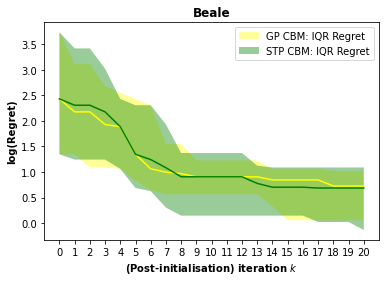

In [95]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_gp, color = 'yellow')
plt.plot(median_stp, color = 'green')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_gp, upper_gp, facecolor = 'yellow', alpha=0.4, label='GP CBM: IQR Regret')
plt.fill_between(xstar, lower_stp, upper_stp, facecolor = 'green', alpha=0.4, label='STP CBM: IQR Regret')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualise!


In [96]:
### acqFunc (x, y) attributes, stddev: run number = 1

gp_1y = gp_1.history[(np.argmin(inverse*gp_1.GP.y[n_init:max_iter+n_init]) * 3) + 1]
gp_1x = gp_1.history[(np.argmin(inverse*gp_1.GP.y[n_init:max_iter+n_init]) * 3) + 2]

stp_1y = stp_1.history[(np.argmin(inverse*stp_1.GP.y[n_init:max_iter+n_init]) * 3) + 1]
stp_1x = stp_1.history[(np.argmin(inverse*stp_1.GP.y[n_init:max_iter+n_init]) * 3) + 2]

gp_1y, gp_1x, stp_1y, stp_1x


(1086.2925873628276, 2.0310011376771646, 2527.106028579377, 2.5103177200485587)

In [97]:
### acqFunc (x, y) attributes, stddev: run number = 2

gp_2y = gp_2.history[(np.argmin(inverse*gp_2.GP.y[n_init:max_iter+n_init]) * 3) + 1]
gp_2x = gp_2.history[(np.argmin(inverse*gp_2.GP.y[n_init:max_iter+n_init]) * 3) + 2]

stp_2y = stp_2.history[(np.argmin(inverse*stp_2.GP.y[n_init:max_iter+n_init]) * 3) + 1]
stp_2x = stp_2.history[(np.argmin(inverse*stp_2.GP.y[n_init:max_iter+n_init]) * 3) + 2]

gp_2y, gp_2x, stp_2y, stp_2x


(57.46421356548333, 1.8632317407044372, 2427.256006664563, 3.2792075321730016)

In [98]:
### acqFunc (x, y) attributes, stddev: run number = 3

gp_3y = gp_3.history[(np.argmin(inverse*gp_3.GP.y[n_init:max_iter+n_init]) * 3) + 1]
gp_3x = gp_3.history[(np.argmin(inverse*gp_3.GP.y[n_init:max_iter+n_init]) * 3) + 2]

stp_3y = stp_3.history[(np.argmin(inverse*stp_3.GP.y[n_init:max_iter+n_init]) * 3) + 1]
stp_3x = stp_3.history[(np.argmin(inverse*stp_3.GP.y[n_init:max_iter+n_init]) * 3) + 2]

gp_3y, gp_3x, stp_3y, stp_3x


(1005.884012609693, 2.6836600833479984, 1495.820234938477, 3.2383783745856487)

In [99]:
### acqFunc (x, y) attributes, stddev: run number = 4

gp_4y = gp_4.history[(np.argmin(inverse*gp_4.GP.y[n_init:max_iter+n_init]) * 3) + 1]
gp_4x = gp_4.history[(np.argmin(inverse*gp_4.GP.y[n_init:max_iter+n_init]) * 3) + 2]

stp_4y = stp_4.history[(np.argmin(inverse*stp_4.GP.y[n_init:max_iter+n_init]) * 3) + 1]
stp_4x = stp_4.history[(np.argmin(inverse*stp_4.GP.y[n_init:max_iter+n_init]) * 3) + 2]

gp_4y, gp_4x, stp_4y, stp_4x


(5.538278728667107, 1.6219709177448987, 17720.448368785725, 2.9203466103204208)

In [100]:
### acqFunc (x, y) attributes, stddev: run number = 5

gp_5y = gp_5.history[(np.argmin(inverse*gp_5.GP.y[n_init:max_iter+n_init]) * 3) + 1]
gp_5x = gp_5.history[(np.argmin(inverse*gp_5.GP.y[n_init:max_iter+n_init]) * 3) + 2]

stp_5y = stp_5.history[(np.argmin(inverse*stp_5.GP.y[n_init:max_iter+n_init]) * 3) + 1]
stp_5x = stp_5.history[(np.argmin(inverse*stp_5.GP.y[n_init:max_iter+n_init]) * 3) + 2]

gp_5y, gp_5x, stp_5y, stp_5x


(469.2006704602144, 2.242151343200304, 10356.1734241599, 2.451123932480883)

In [101]:
### acqFunc (x, y) attributes, stddev: run number = 6

gp_6y = gp_6.history[(np.argmin(inverse*gp_6.GP.y[n_init:max_iter+n_init]) * 3) + 1]
gp_6x = gp_6.history[(np.argmin(inverse*gp_6.GP.y[n_init:max_iter+n_init]) * 3) + 2]

stp_6y = stp_6.history[(np.argmin(inverse*stp_6.GP.y[n_init:max_iter+n_init]) * 3) + 1]
stp_6x = stp_6.history[(np.argmin(inverse*stp_6.GP.y[n_init:max_iter+n_init]) * 3) + 2]

gp_6y, gp_6x, stp_6y, stp_6x


(1820.3863074785029, 2.864276845314282, 5032.762727012194, 2.7698183118390496)

In [102]:
### acqFunc (x, y) attributes, stddev: run number = 7

gp_7y = gp_7.history[(np.argmin(inverse*gp_7.GP.y[n_init:max_iter+n_init]) * 3) + 1]
gp_7x = gp_7.history[(np.argmin(inverse*gp_7.GP.y[n_init:max_iter+n_init]) * 3) + 2]

stp_7y = stp_7.history[(np.argmin(inverse*stp_7.GP.y[n_init:max_iter+n_init]) * 3) + 1]
stp_7x = stp_7.history[(np.argmin(inverse*stp_7.GP.y[n_init:max_iter+n_init]) * 3) + 2]

gp_7y, gp_7x, stp_7y, stp_7x


(65.0216333209181, 2.30019661363958, 424.1070678053019, 3.384052721437888)

In [103]:
### acqFunc (x, y) attributes, stddev: run number = 8

gp_8y = gp_8.history[(np.argmin(inverse*gp_8.GP.y[n_init:max_iter+n_init]) * 3) + 1]
gp_8x = gp_8.history[(np.argmin(inverse*gp_8.GP.y[n_init:max_iter+n_init]) * 3) + 2]

stp_8y = stp_8.history[(np.argmin(inverse*stp_8.GP.y[n_init:max_iter+n_init]) * 3) + 1]
stp_8x = stp_8.history[(np.argmin(inverse*stp_8.GP.y[n_init:max_iter+n_init]) * 3) + 2]

gp_8y, gp_8x, stp_8y, stp_8x


(3676.5558355065964, 2.6787972358267114, 2911.98104791076, 3.3175632670512383)

In [104]:
### acqFunc (x, y) attributes, stddev: run number = 9

gp_9y = gp_9.history[(np.argmin(inverse*gp_9.GP.y[n_init:max_iter+n_init]) * 3) + 1]
gp_9x = gp_9.history[(np.argmin(inverse*gp_9.GP.y[n_init:max_iter+n_init]) * 3) + 2]

stp_9y = stp_9.history[(np.argmin(inverse*stp_9.GP.y[n_init:max_iter+n_init]) * 3) + 1]
stp_9x = stp_9.history[(np.argmin(inverse*stp_9.GP.y[n_init:max_iter+n_init]) * 3) + 2]

gp_9y, gp_9x, stp_9y, stp_9x


(3.72943778296683, 2.5067226481197213, 1254.8545964389123, 3.027490655662942)

In [105]:
### acqFunc (x, y) attributes, stddev: run number = 10

gp_10y = gp_10.history[(np.argmin(inverse*gp_10.GP.y[n_init:max_iter+n_init]) * 3) + 1]
gp_10x = gp_10.history[(np.argmin(inverse*gp_10.GP.y[n_init:max_iter+n_init]) * 3) + 2]

stp_10y = stp_10.history[(np.argmin(inverse*stp_10.GP.y[n_init:max_iter+n_init]) * 3) + 1]
stp_10x = stp_10.history[(np.argmin(inverse*stp_10.GP.y[n_init:max_iter+n_init]) * 3) + 2]

gp_10y, gp_10x, stp_10y, stp_10x


(677.6979871495419, 3.4685247344458663, 1365.0203794485533, 2.7698894871941038)

In [106]:
### acqFunc (x, y) attributes, stddev: run number = 11

gp_11y = gp_11.history[(np.argmin(inverse*gp_11.GP.y[n_init:max_iter+n_init]) * 3) + 1]
gp_11x = gp_11.history[(np.argmin(inverse*gp_11.GP.y[n_init:max_iter+n_init]) * 3) + 2]

stp_11y = stp_11.history[(np.argmin(inverse*stp_11.GP.y[n_init:max_iter+n_init]) * 3) + 1]
stp_11x = stp_11.history[(np.argmin(inverse*stp_11.GP.y[n_init:max_iter+n_init]) * 3) + 2]

gp_11y, gp_11x, stp_11y, stp_11x


(649.071214802282, 1.7265798943276922, 1974.0652760529988, 2.576826048224675)

In [107]:
### acqFunc (x, y) attributes, stddev: run number = 12

gp_12y = gp_12.history[(np.argmin(inverse*gp_12.GP.y[n_init:max_iter+n_init]) * 3) + 1]
gp_12x = gp_12.history[(np.argmin(inverse*gp_12.GP.y[n_init:max_iter+n_init]) * 3) + 2]

stp_12y = stp_12.history[(np.argmin(inverse*stp_12.GP.y[n_init:max_iter+n_init]) * 3) + 1]
stp_12x = stp_12.history[(np.argmin(inverse*stp_12.GP.y[n_init:max_iter+n_init]) * 3) + 2]

gp_12y, gp_12x, stp_12y, stp_12x


(122.6625044393045, 3.6541410262481424, 3217.253766959576, 1.7738412035365474)

In [108]:
### acqFunc (x, y) attributes, stddev: run number = 13

gp_13y = gp_13.history[(np.argmin(inverse*gp_13.GP.y[n_init:max_iter+n_init]) * 3) + 1]
gp_13x = gp_13.history[(np.argmin(inverse*gp_13.GP.y[n_init:max_iter+n_init]) * 3) + 2]

stp_13y = stp_13.history[(np.argmin(inverse*stp_13.GP.y[n_init:max_iter+n_init]) * 3) + 1]
stp_13x = stp_13.history[(np.argmin(inverse*stp_13.GP.y[n_init:max_iter+n_init]) * 3) + 2]

gp_13y, gp_13x, stp_13y, stp_13x


(9.252899367055184, 2.0058627776595337, 6083.369620020435, 2.6784687312709883)

In [109]:
### acqFunc (x, y) attributes, stddev: run number = 14

gp_14y = gp_14.history[(np.argmin(inverse*gp_14.GP.y[n_init:max_iter+n_init]) * 3) + 1]
gp_14x = gp_14.history[(np.argmin(inverse*gp_14.GP.y[n_init:max_iter+n_init]) * 3) + 2]

stp_14y = stp_14.history[(np.argmin(inverse*stp_14.GP.y[n_init:max_iter+n_init]) * 3) + 1]
stp_14x = stp_14.history[(np.argmin(inverse*stp_14.GP.y[n_init:max_iter+n_init]) * 3) + 2]

gp_14y, gp_14x, stp_14y, stp_14x


(27.97937161565722, 1.8316436933908107, 1392.6342804564406, 3.06235185643374)

In [110]:
### acqFunc (x, y) attributes, stddev: run number = 15

gp_15y = gp_15.history[(np.argmin(inverse*gp_15.GP.y[n_init:max_iter+n_init]) * 3) + 1]
gp_15x = gp_15.history[(np.argmin(inverse*gp_15.GP.y[n_init:max_iter+n_init]) * 3) + 2]

stp_15y = stp_15.history[(np.argmin(inverse*stp_15.GP.y[n_init:max_iter+n_init]) * 3) + 1]
stp_15x = stp_15.history[(np.argmin(inverse*stp_15.GP.y[n_init:max_iter+n_init]) * 3) + 2]

gp_15y, gp_15x, stp_15y, stp_15x


(23.020006910590478, 3.1896883449999818, 11212.62735447864, 2.1743701733741863)

In [111]:
### acqFunc (x, y) attributes, stddev: run number = 16

gp_16y = gp_16.history[(np.argmin(inverse*gp_16.GP.y[n_init:max_iter+n_init]) * 3) + 1]
gp_16x = gp_16.history[(np.argmin(inverse*gp_16.GP.y[n_init:max_iter+n_init]) * 3) + 2]

stp_16y = stp_16.history[(np.argmin(inverse*stp_16.GP.y[n_init:max_iter+n_init]) * 3) + 1]
stp_16x = stp_16.history[(np.argmin(inverse*stp_16.GP.y[n_init:max_iter+n_init]) * 3) + 2]

gp_16y, gp_16x, stp_16y, stp_16x


(4.443389806177474, 2.6126466159528587, 4151.981770142122, 2.5472360147640978)

In [112]:
### acqFunc (x, y) attributes, stddev: run number = 17

gp_17y = gp_17.history[(np.argmin(inverse*gp_17.GP.y[n_init:max_iter+n_init]) * 3) + 1]
gp_17x = gp_17.history[(np.argmin(inverse*gp_17.GP.y[n_init:max_iter+n_init]) * 3) + 2]

stp_17y = stp_17.history[(np.argmin(inverse*stp_17.GP.y[n_init:max_iter+n_init]) * 3) + 1]
stp_17x = stp_17.history[(np.argmin(inverse*stp_17.GP.y[n_init:max_iter+n_init]) * 3) + 2]

gp_17y, gp_17x, stp_17y, stp_17x


(847.355004595906, 2.0026096765470216, 745.2431117924865, 2.792238772819917)

In [113]:
### acqFunc (x, y) attributes, stddev: run number = 18

gp_18y = gp_18.history[(np.argmin(inverse*gp_18.GP.y[n_init:max_iter+n_init]) * 3) + 1]
gp_18x = gp_18.history[(np.argmin(inverse*gp_18.GP.y[n_init:max_iter+n_init]) * 3) + 2]

stp_18y = stp_18.history[(np.argmin(inverse*stp_18.GP.y[n_init:max_iter+n_init]) * 3) + 1]
stp_18x = stp_18.history[(np.argmin(inverse*stp_18.GP.y[n_init:max_iter+n_init]) * 3) + 2]

gp_18y, gp_18x, stp_18y, stp_18x


(310.56948347672557, 3.323595127766741, 17643.31929423324, 2.7158315711161425)

In [114]:
### acqFunc (x, y) attributes, stddev: run number = 19

gp_19y = gp_19.history[(np.argmin(inverse*gp_19.GP.y[n_init:max_iter+n_init]) * 3) + 1]
gp_19x = gp_19.history[(np.argmin(inverse*gp_19.GP.y[n_init:max_iter+n_init]) * 3) + 2]

stp_19y = stp_19.history[(np.argmin(inverse*stp_19.GP.y[n_init:max_iter+n_init]) * 3) + 1]
stp_19x = stp_19.history[(np.argmin(inverse*stp_19.GP.y[n_init:max_iter+n_init]) * 3) + 2]

gp_19y, gp_19x, stp_19y, stp_19x


(48.71628986937065, 3.6883752681753044, 3589.865807509624, 2.9835082059878064)

In [115]:
### acqFunc (x, y) attributes, stddev: run number = 20

gp_20y = gp_20.history[(np.argmin(inverse*gp_20.GP.y[n_init:max_iter+n_init]) * 3) + 1]
gp_20x = gp_20.history[(np.argmin(inverse*gp_20.GP.y[n_init:max_iter+n_init]) * 3) + 2]

stp_20y = stp_20.history[(np.argmin(inverse*stp_20.GP.y[n_init:max_iter+n_init]) * 3) + 1]
stp_20x = stp_20.history[(np.argmin(inverse*stp_20.GP.y[n_init:max_iter+n_init]) * 3) + 2]

gp_20y, gp_20x, stp_20y, stp_20x


(58.095615420730006, 2.2521190060614353, 356.2235375704948, 2.397311131745616)

In [116]:
### Summarise arrays: 

gp_y_stddev = np.sort([gp_1y,gp_2y,gp_3y,gp_4y,gp_5y,gp_6y,gp_7y,gp_8y,gp_9y,gp_10y,gp_11y,gp_12y,gp_13y,gp_14y,gp_15y,gp_16y,gp_17y,gp_18y,gp_19y,gp_20y])
stp_y_stddev = np.sort([stp_1y,stp_2y,stp_3y,stp_4y,stp_5y,stp_6y,stp_7y,stp_8y,stp_9y,stp_10y,stp_11y,stp_12y,stp_13y,stp_14y,stp_15y,stp_16y,stp_17y,stp_18y,stp_19y,stp_20y])

gp_x_stddev = np.sort([gp_1x,gp_2x,gp_3x,gp_4x,gp_5x,gp_6x,gp_7x,gp_8x,gp_9x,gp_10x,gp_11x,gp_12x,gp_13x,gp_14x,gp_15x,gp_16x,gp_17x,gp_18x,gp_19x,gp_20x])
stp_x_stddev = np.sort([stp_1x,stp_2x,stp_3x,stp_4x,stp_5x,stp_6x,stp_7x,stp_8x,stp_9x,stp_10x,stp_11x,stp_12x,stp_13x,stp_14x,stp_15x,stp_16x,stp_17x,stp_18x,stp_19x,stp_20x])


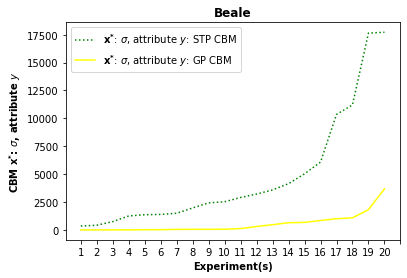

In [117]:
### Visualise: attribute y

title = obj_func
plt.figure()

plt.plot(stp_y_stddev, color = 'Green', ls=':', label='$\mathbf{x^{*}}$: $\sigma$, attribute $y$: STP CBM')
plt.plot(gp_y_stddev, color = 'Yellow', ls='-', label='$\mathbf{x^{*}}$: $\sigma$, attribute $y$: GP CBM')

plt.title(title, weight = 'bold')
plt.xlabel('Experiment(s)', weight = 'bold')
plt.ylabel('CBM $\mathbf{x^{*}}$: $\sigma$, attribute $y$', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show() #visualise!


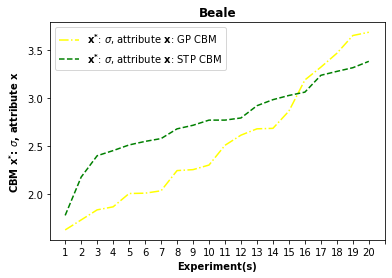

In [118]:
### Visualise: attribute x

title = obj_func
plt.figure()

plt.plot(gp_x_stddev, color = 'Yellow', ls='-.', label='$\mathbf{x^{*}}$: $\sigma$, attribute $\mathbf{x}$: GP CBM')
plt.plot(stp_x_stddev, color = 'Green', ls='--', label='$\mathbf{x^{*}}$: $\sigma$, attribute $\mathbf{x}$: STP CBM')

plt.title(title, weight = 'bold')
plt.xlabel('Experiment(s)', weight = 'bold')
plt.ylabel('CBM $\mathbf{x^{*}}$: $\sigma$, attribute $\mathbf{x}$', weight = 'bold') 
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count))
plt.show() #visualise!
